How to run a star cluster simulation
====================

More realistic star clusters have stars that move and evolve in time.
The movement of stars is caused by their mutual gravity, which we will take care of by means of integrating the equations of motion under Newtonian forces. This is realized using, what we call, and N-body code. Stellar evolution influences the gravitational dynamics by altering the mass of the N-body particles. It is taken care of by means of a parametrized stellar evolution code.

For reference you can read chapter 4 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate inital conditions (mass-function, Plummer model)
- to initialize gravitational N-body codes and parametrized stellar evolution codes
- channels and intra-code data transfer
- plotting results

In [6]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import units
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['font.size'] = 15.0


from amuse.community.ph4.interface import ph4
from amuse.community.seba.interface import SeBa
from amuse.ext.LagrangianRadii import LagrangianRadii
from amuse.plot import plot

Let's start by generating the initial conditions.
This includes a mass function (for which we adopt the Salpeter power-law), and a Plummer sphere for the spatial distribution. After assigning the masses to the stars in the Plummer sphere, we scale the entire system to virial equilibrium.

In [2]:
n_stars = 100
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_stars = new_powerlaw_mass_distribution(n_stars, 
                                         10.0|units.MSun, 
                                         100.0|units.MSun, 
                                         alpha_IMF)

r_cluster = 1.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_stars.sum(), r_cluster)
from amuse.ic.plummer import new_plummer_model
stars=new_plummer_model(n_stars, convert_nbody=converter)
stars.mass = m_stars
stars.scale_to_standard(converter)

Let's check if this is what we expected.

In [3]:
def plot_snapshot(bodies):
    # size is stellar mass, color is velocity
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    s = bodies.mass.value_in(units.MSun)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ax1.scatter(stars.temperature.value_in(units.K),
                stars.luminosity.value_in(units.LSun), 
                c=v.value_in(units.kms),
                s=s)
    ax1.set_xlim(6.e+4, 20000)
    ax1.set_ylim(1.e+3, 1.e+7)
    ax1.loglog()
    ax1.set_xlabel("T [K]")
    ax1.set_ylabel("L [$L_\odot$]")
    ax1.set_title("HR-diagram")
    ax2.scatter(bodies.x.value_in(units.pc), 
                bodies.y.value_in(units.pc), 
                c=v.value_in(units.kms), 
                s=s)
    plt.gca().set_aspect('equal', adjustable='box')
    ax2.set_xlabel("x [pc]")
    ax2.set_ylabel("y [pc]")
    ax2.set_title("Positions")
    ax2.set_xlim(-5, 5)
    ax2.set_ylim(-5, 5)
    plt.show()


In [ ]:
from amuse.community.ph4.interface import ph4
from amuse.community.seba.interface import SeBa
from amuse.ext.LagrangianRadii import LagrangianRadii

stellar = SeBa()
stellar.particles.add_particles(stars)

gravity = ph4(converter)
gravity.particles.add_particles(stars)
ch_s2g = stellar.particles.new_channel_to(gravity.particles)
ch_g2l = gravity.particles.new_channel_to(stars)
ch_s2l = stellar.particles.new_channel_to(stars)
ch_s2l.copy()

plot_snapshot(stars)

Now let's run the code. Why is the coupling timescale between gravity and stellar evolution chosen the way it is?

In [ ]:
end_time = 10.0 | units.Myr
model_time = 0 | units.Myr
while(model_time<end_time):
    dt = stellar.particles.time_step.min()
    model_time += dt
    stellar.evolve_model(model_time)
    ch_s2g.copy()
    ch_s2l.copy()
    gravity.evolve_model(model_time)
    ch_g2l.copy()
    print("Evolved to t=", stellar.model_time.in_(units.Myr), 
          gravity.model_time.in_(units.Myr),
         "mass=", stars.mass.sum().in_(units.MSun), 
          "rvir=", stars.virial_radius().in_(units.pc))
    
plot_snapshot(stars)
stellar.stop()
gravity.stop()

You have performed a small experiment in which a population of stars was evolved from zero-age to an age of 10 Myr.
The stars were selected randomly from a Salpeter mass function, and distributed in a virialized Plummer sphere with a characteristic (Plummer) radius of 1 pc.

Assignments and questions:
---------------

### Question 1:
You have plotted the Hertzsprung-Russel diagram and the x-y projection of the cluster before and after the simulation. Describe the differences.

<span style="color:purple;font-weight:700">
After the simulation, the positions are much more spread out than before. There are also far fewer high-mass stars, and the HR-diagram now shows what looks like a giant branch. 
</span>

### Assignment 1:
Rerun the calculation, but store the time and the virial radius in arrays. Make a plot of the virial radius as a function of time.

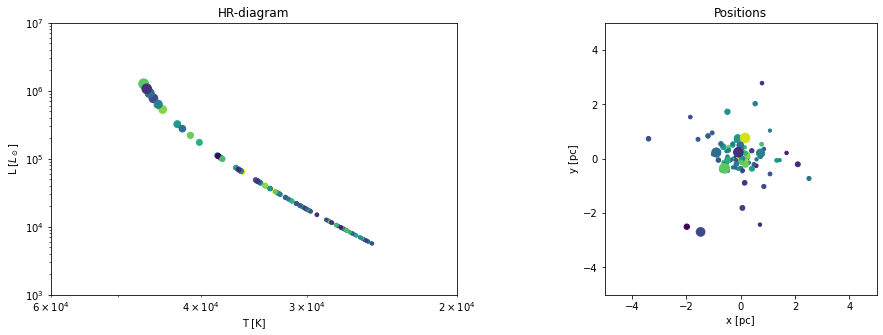

Evolved to t= 0.018142356843 Myr 0.0184400673228 Myr mass= 2096.62707572 MSun rvir= 0.994011789642 parsec
Evolved to t= 0.0362434896488 Myr 0.0362442702552 Myr mass= 2096.38308455 MSun rvir= 0.99143949464 parsec
Evolved to t= 0.0543169377783 Myr 0.0546843375781 Myr mass= 2096.13822104 MSun rvir= 0.991690081262 parsec
Evolved to t= 0.0723625286457 Myr 0.0724885405105 Myr mass= 2095.8924837 MSun rvir= 0.986139537282 parsec
Evolved to t= 0.0903801035689 Myr 0.0906106756381 Myr mass= 2095.64587087 MSun rvir= 0.981266956889 parsec
Evolved to t= 0.108369507371 Myr 0.108414878571 Myr mass= 2095.39838086 MSun rvir= 0.975253002517 parsec
Evolved to t= 0.12633058838 Myr 0.126537013698 Myr mass= 2095.15001194 MSun rvir= 0.979331407127 parsec
Evolved to t= 0.144263198423 Myr 0.144341216631 Myr mass= 2094.90076234 MSun rvir= 0.980435074454 parsec
Evolved to t= 0.162167192819 Myr 0.162463351758 Myr mass= 2094.65063028 MSun rvir= 0.973708917348 parsec
Evolved to t= 0.180042430365 Myr 0.180108588593 M

Evolved to t= 1.40182888013 Myr 1.40208098093 Myr mass= 2073.58169974 MSun rvir= 0.996733438305 parsec
Evolved to t= 1.41740211418 Myr 1.41797759069 Myr mass= 2073.26187396 MSun rvir= 1.00005321821 parsec
Evolved to t= 1.43294433151 Myr 1.43299988691 Myr mass= 2072.94114499 MSun rvir= 0.931599952312 parsec
Evolved to t= 1.44845558386 Myr 1.44849908143 Myr mass= 2072.61951695 MSun rvir= 1.02286661359 parsec
Evolved to t= 1.46393592424 Myr 1.46439569119 Myr mass= 2072.29699416 MSun rvir= 1.04171135435 parsec
Evolved to t= 1.47938540686 Myr 1.47965643656 Myr mass= 2071.97358116 MSun rvir= 1.04647206147 parsec
Evolved to t= 1.49480408714 Myr 1.49491718193 Myr mass= 2071.6492827 MSun rvir= 0.980151188121 parsec
Evolved to t= 1.51019202162 Myr 1.5104958595 Myr mass= 2071.32410376 MSun rvir= 1.06289053068 parsec
Evolved to t= 1.52554926796 Myr 1.52607453706 Myr mass= 2070.99804953 MSun rvir= 1.08124191657 parsec
Evolved to t= 1.54087588486 Myr 1.54093786719 Myr mass= 2070.67112545 MSun rvir= 

Evolved to t= 2.64792799327 Myr 2.648057254 Myr mass= 2040.51164873 MSun rvir= 1.02189797831 parsec
Evolved to t= 2.66185715209 Myr 2.66188730449 Myr mass= 2039.91771417 MSun rvir= 1.01718266652 parsec
Evolved to t= 2.67582788952 Myr 2.67587632108 Myr mass= 2039.32156057 MSun rvir= 0.997060270382 parsec
Evolved to t= 2.68984116812 Myr 2.68984546691 Myr mass= 2038.72318803 MSun rvir= 0.891643278982 parsec
Evolved to t= 2.70389798633 Myr 2.70391396655 Myr mass= 2038.12259758 MSun rvir= 0.82973854468 parsec
Evolved to t= 2.71799938032 Myr 2.71800233695 Myr mass= 2037.5197913 MSun rvir= 1.00515762561 parsec
Evolved to t= 2.732146426 Myr 2.73215031964 Myr mass= 2036.91477235 MSun rvir= 1.05014486228 parsec
Evolved to t= 2.74634024115 Myr 2.74645726842 Myr mass= 2036.30754493 MSun rvir= 1.07112958716 parsec
Evolved to t= 2.76058198769 Myr 2.76060525111 Myr mass= 2035.69811442 MSun rvir= 1.0980635426 parsec
Evolved to t= 2.77487287416 Myr 2.77491219989 Myr mass= 2035.08648729 MSun rvir= 1.113

Evolved to t= 3.40545080493 Myr 3.40545122607 Myr mass= 1987.72706768 MSun rvir= 0.881161125178 parsec
Evolved to t= 3.40665325651 Myr 3.40666334256 Myr mass= 1987.59687113 MSun rvir= 0.892549961224 parsec
Evolved to t= 3.40779705525 Myr 3.40783571753 Myr mass= 1987.45683288 MSun rvir= 1.00835258092 parsec
Evolved to t= 3.40888498732 Myr 3.40902796326 Myr mass= 1987.33862076 MSun rvir= 1.04413239215 parsec
Evolved to t= 3.40991972931 Myr 3.40998175985 Myr mass= 1987.21187412 MSun rvir= 1.05917735174 parsec
Evolved to t= 3.41090384801 Myr 3.41109452253 Myr mass= 1987.10462899 MSun rvir= 1.07018178641 parsec
Evolved to t= 3.41183980125 Myr 3.41204831912 Myr mass= 1986.9892089 MSun rvir= 1.07624962758 parsec
Evolved to t= 3.41272993933 Myr 3.4130021157 Myr mass= 1986.879664 MSun rvir= 1.08003730237 parsec
Evolved to t= 3.41357650728 Myr 3.41363798009 Myr mass= 1986.78709391 MSun rvir= 1.08147265783 parsec
Evolved to t= 3.41438164735 Myr 3.41459177668 Myr mass= 1986.69896257 MSun rvir= 1.0

Evolved to t= 3.42988590538 Myr 3.42989226357 Myr mass= 1984.89574927 MSun rvir= 1.10175333046 parsec
Evolved to t= 3.42990470591 Myr 3.4299320051 Myr mass= 1984.89375488 MSun rvir= 1.10163417179 parsec
Evolved to t= 3.42992262359 Myr 3.4299320051 Myr mass= 1984.89158726 MSun rvir= 1.10163420355 parsec
Evolved to t= 3.42993969996 Myr 3.42997174662 Myr mass= 1984.88957845 MSun rvir= 1.10151073369 parsec
Evolved to t= 3.42995597458 Myr 3.42997174662 Myr mass= 1984.88785207 MSun rvir= 1.1015109718 parsec
Evolved to t= 3.42997148516 Myr 3.42997174662 Myr mass= 1984.88620674 MSun rvir= 1.10151119874 parsec
Evolved to t= 3.42998626762 Myr 3.43001148815 Myr mass= 1984.88422157 MSun rvir= 1.10138316597 parsec
Evolved to t= 3.43000035619 Myr 3.43001148815 Myr mass= 1984.88256425 MSun rvir= 1.10138342005 parsec
Evolved to t= 3.43001378349 Myr 3.43005122967 Myr mass= 1984.88113997 MSun rvir= 1.10125099953 parsec
Evolved to t= 3.43002658059 Myr 3.43005122967 Myr mass= 1984.87978254 MSun rvir= 1.10

Evolved to t= 3.43027986736 Myr 3.43028967882 Myr mass= 1984.85054002 MSun rvir= 1.10036231517 parsec
Evolved to t= 3.43028018448 Myr 3.43028967882 Myr mass= 1984.85050639 MSun rvir= 1.10036231975 parsec
Evolved to t= 3.43028048673 Myr 3.43028967882 Myr mass= 1984.85047433 MSun rvir= 1.10036232412 parsec
Evolved to t= 3.43028077482 Myr 3.43028967882 Myr mass= 1984.85044044 MSun rvir= 1.10036232927 parsec
Evolved to t= 3.43028104941 Myr 3.43028967882 Myr mass= 1984.85040723 MSun rvir= 1.1003623297 parsec
Evolved to t= 3.43028131112 Myr 3.43028967882 Myr mass= 1984.85037947 MSun rvir= 1.10036233348 parsec
Evolved to t= 3.43028156057 Myr 3.43028967882 Myr mass= 1984.85034684 MSun rvir= 1.10036233983 parsec
Evolved to t= 3.43028179832 Myr 3.43028967882 Myr mass= 1984.85032163 MSun rvir= 1.10036234327 parsec
Evolved to t= 3.43028202493 Myr 3.43028967882 Myr mass= 1984.85029421 MSun rvir= 1.10036234362 parsec
Evolved to t= 3.43028224092 Myr 3.43028967882 Myr mass= 1984.85027131 MSun rvir= 1.

Evolved to t= 3.43028650718 Myr 3.43028967882 Myr mass= 1984.84978058 MSun rvir= 1.10036240241 parsec
Evolved to t= 3.43028651308 Myr 3.43028967882 Myr mass= 1984.84977989 MSun rvir= 1.10036240251 parsec
Evolved to t= 3.4302865187 Myr 3.43028967882 Myr mass= 1984.84977929 MSun rvir= 1.10036240259 parsec
Evolved to t= 3.43028652406 Myr 3.43028967882 Myr mass= 1984.84977873 MSun rvir= 1.10036240267 parsec
Evolved to t= 3.43028652917 Myr 3.43028967882 Myr mass= 1984.84977798 MSun rvir= 1.10036240273 parsec
Evolved to t= 3.43028653404 Myr 3.43028967882 Myr mass= 1984.84977747 MSun rvir= 1.1003624028 parsec
Evolved to t= 3.43028653868 Myr 3.43028967882 Myr mass= 1984.84977697 MSun rvir= 1.10036240287 parsec
Evolved to t= 3.4302865431 Myr 3.43028967882 Myr mass= 1984.8497765 MSun rvir= 1.10036240294 parsec
Evolved to t= 3.43028654732 Myr 3.43028967882 Myr mass= 1984.84977595 MSun rvir= 1.10036240296 parsec
Evolved to t= 3.43028655133 Myr 3.43028967882 Myr mass= 1984.84977552 MSun rvir= 1.100

Evolved to t= 3.43098504787 Myr 3.43100502626 Myr mass= 1984.69913335 MSun rvir= 1.09661805235 parsec
Evolved to t= 3.43101310934 Myr 3.43104476778 Myr mass= 1984.69228255 MSun rvir= 1.09635346719 parsec
Evolved to t= 3.43104118049 Myr 3.43104476778 Myr mass= 1984.68584913 MSun rvir= 1.09635593031 parsec
Evolved to t= 3.43106926131 Myr 3.43108450931 Myr mass= 1984.6790868 MSun rvir= 1.09608520052 parsec
Evolved to t= 3.43109735181 Myr 3.43112425083 Myr mass= 1984.67222765 MSun rvir= 1.09580729159 parsec
Evolved to t= 3.431125452 Myr 3.43116399235 Myr mass= 1984.66542715 MSun rvir= 1.09552309691 parsec
Evolved to t= 3.43115356188 Myr 3.43116399235 Myr mass= 1984.65865662 MSun rvir= 1.09552564494 parsec
Evolved to t= 3.43118168147 Myr 3.43120373388 Myr mass= 1984.65178916 MSun rvir= 1.09523389324 parsec
Evolved to t= 3.43120981076 Myr 3.4312434754 Myr mass= 1984.64501312 MSun rvir= 1.09493547283 parsec
Evolved to t= 3.43123794977 Myr 3.4312434754 Myr mass= 1984.63856158 MSun rvir= 1.0949

Evolved to t= 3.43337656359 Myr 3.43338951772 Myr mass= 1984.12206618 MSun rvir= 1.06107673361 parsec
Evolved to t= 3.43340546109 Myr 3.43340938848 Myr mass= 1984.11463452 MSun rvir= 1.06047915532 parsec
Evolved to t= 3.43343436885 Myr 3.43344913001 Myr mass= 1984.10796793 MSun rvir= 1.05925440344 parsec
Evolved to t= 3.43346328687 Myr 3.43346900077 Myr mass= 1984.10129814 MSun rvir= 1.05862863446 parsec
Evolved to t= 3.43349221515 Myr 3.43350874229 Myr mass= 1984.09385701 MSun rvir= 1.05734476588 parsec
Evolved to t= 3.43352115371 Myr 3.43352861306 Myr mass= 1984.08684477 MSun rvir= 1.05668874111 parsec
Evolved to t= 3.43354793361 Myr 3.43354848382 Myr mass= 1984.08066598 MSun rvir= 1.05602178602 parsec
Evolved to t= 3.43357254654 Myr 3.43358822534 Myr mass= 1984.07469708 MSun rvir= 1.05465308132 parsec
Evolved to t= 3.43359516657 Myr 3.43359816072 Myr mass= 1984.0691433 MSun rvir= 1.05430475324 parsec
Evolved to t= 3.433615954 Myr 3.43362796687 Myr mass= 1984.06434577 MSun rvir= 1.05

Evolved to t= 3.43385047384 Myr 3.43385648063 Myr mass= 1984.00917197 MSun rvir= 1.04411277371 parsec
Evolved to t= 3.43385050642 Myr 3.43385648063 Myr mass= 1984.00916397 MSun rvir= 1.0441127755 parsec
Evolved to t= 3.43385053634 Myr 3.43385648063 Myr mass= 1984.0091567 MSun rvir= 1.04411277758 parsec
Evolved to t= 3.43385056382 Myr 3.43385648063 Myr mass= 1984.00915035 MSun rvir= 1.04411277942 parsec
Evolved to t= 3.43385058905 Myr 3.43385648063 Myr mass= 1984.00914452 MSun rvir= 1.04411278111 parsec
Evolved to t= 3.43385061223 Myr 3.43385648063 Myr mass= 1984.00913917 MSun rvir= 1.04411278266 parsec
Evolved to t= 3.43385063352 Myr 3.43385648063 Myr mass= 1984.00913425 MSun rvir= 1.04411278409 parsec
Evolved to t= 3.43385065307 Myr 3.43385648063 Myr mass= 1984.0091295 MSun rvir= 1.04411278545 parsec
Evolved to t= 3.43385067103 Myr 3.43385648063 Myr mass= 1984.00912509 MSun rvir= 1.04411278643 parsec
Evolved to t= 3.43385068753 Myr 3.43385648063 Myr mass= 1984.00912128 MSun rvir= 1.04

Evolved to t= 3.47358409977 Myr 3.47372716499 Myr mass= 1973.72059077 MSun rvir= 1.11347183285 parsec
Evolved to t= 3.47414333686 Myr 3.47436302938 Myr mass= 1973.5698126 MSun rvir= 1.11218778695 parsec
Evolved to t= 3.47467539196 Myr 3.47468096158 Myr mass= 1973.43401441 MSun rvir= 1.11119649886 parsec
Evolved to t= 3.47518161196 Myr 3.47531682597 Myr mass= 1973.30492068 MSun rvir= 1.10834749326 parsec
Evolved to t= 3.47566327629 Myr 3.47595269036 Myr mass= 1973.18219373 MSun rvir= 1.10417485962 parsec
Evolved to t= 3.47612160012 Myr 3.47627062255 Myr mass= 1973.05896799 MSun rvir= 1.10148820807 parsec
Evolved to t= 3.47655773749 Myr 3.47658855475 Myr mass= 1972.94803035 MSun rvir= 1.09829156865 parsec
Evolved to t= 3.47697278434 Myr 3.47706545304 Myr mass= 1972.8425449 MSun rvir= 1.09230337007 parsec
Evolved to t= 3.47736778134 Myr 3.47738338523 Myr mass= 1972.74223715 MSun rvir= 1.08731824888 parsec
Evolved to t= 3.47774371668 Myr 3.47786028353 Myr mass= 1972.64144042 MSun rvir= 1.0

Evolved to t= 3.48506303921 Myr 3.48509324097 Myr mass= 1970.77643066 MSun rvir= 1.10136185541 parsec
Evolved to t= 3.48507252854 Myr 3.48509324097 Myr mass= 1970.77393188 MSun rvir= 1.1013625257 parsec
Evolved to t= 3.48508157299 Myr 3.48509324097 Myr mass= 1970.77168454 MSun rvir= 1.10136311865 parsec
Evolved to t= 3.48509019343 Myr 3.48509324097 Myr mass= 1970.76954263 MSun rvir= 1.10136368381 parsec
Evolved to t= 3.48509840975 Myr 3.48513298249 Myr mass= 1970.76750118 MSun rvir= 1.10169051175 parsec
Evolved to t= 3.48510624092 Myr 3.48513298249 Myr mass= 1970.76543925 MSun rvir= 1.10169106585 parsec
Evolved to t= 3.485113705 Myr 3.48513298249 Myr mass= 1970.76358481 MSun rvir= 1.10169155601 parsec
Evolved to t= 3.48512081922 Myr 3.48513298249 Myr mass= 1970.76181734 MSun rvir= 1.10169202321 parsec
Evolved to t= 3.48512759998 Myr 3.48513298249 Myr mass= 1970.7600321 MSun rvir= 1.101692503 parsec
Evolved to t= 3.48513406292 Myr 3.48517272402 Myr mass= 1970.75842651 MSun rvir= 1.10201

Evolved to t= 3.48526193928 Myr 3.48529194859 Myr mass= 1970.72617878 MSun rvir= 1.10293590271 parsec
Evolved to t= 3.48526210786 Myr 3.48529194859 Myr mass= 1970.72613692 MSun rvir= 1.10293591385 parsec
Evolved to t= 3.48526226854 Myr 3.48529194859 Myr mass= 1970.72609702 MSun rvir= 1.10293592447 parsec
Evolved to t= 3.4852624217 Myr 3.48529194859 Myr mass= 1970.72605899 MSun rvir= 1.10293593459 parsec
Evolved to t= 3.48526256768 Myr 3.48529194859 Myr mass= 1970.72602057 MSun rvir= 1.10293594499 parsec
Evolved to t= 3.48526270682 Myr 3.48529194859 Myr mass= 1970.72598602 MSun rvir= 1.10293595418 parsec
Evolved to t= 3.48526283945 Myr 3.48529194859 Myr mass= 1970.72595309 MSun rvir= 1.10293596295 parsec
Evolved to t= 3.48526296587 Myr 3.48529194859 Myr mass= 1970.72591982 MSun rvir= 1.10293597195 parsec
Evolved to t= 3.48526308636 Myr 3.48529194859 Myr mass= 1970.7258899 MSun rvir= 1.10293597991 parsec
Evolved to t= 3.48526320121 Myr 3.48529194859 Myr mass= 1970.72586138 MSun rvir= 1.1

Evolved to t= 3.48526547441 Myr 3.48529194859 Myr mass= 1970.72528787 MSun rvir= 1.10293614086 parsec
Evolved to t= 3.48526547741 Myr 3.48529194859 Myr mass= 1970.72528713 MSun rvir= 1.10293614106 parsec
Evolved to t= 3.48526548027 Myr 3.48529194859 Myr mass= 1970.72528642 MSun rvir= 1.10293614125 parsec
Evolved to t= 3.48526548299 Myr 3.48529194859 Myr mass= 1970.7252857 MSun rvir= 1.10293614144 parsec
Evolved to t= 3.48526548559 Myr 3.48529194859 Myr mass= 1970.72528506 MSun rvir= 1.10293614161 parsec
Evolved to t= 3.48526548806 Myr 3.48529194859 Myr mass= 1970.72528444 MSun rvir= 1.10293614178 parsec
Evolved to t= 3.48526549042 Myr 3.48529194859 Myr mass= 1970.72528385 MSun rvir= 1.10293614193 parsec
Evolved to t= 3.48526549267 Myr 3.48529194859 Myr mass= 1970.72528326 MSun rvir= 1.10293614209 parsec
Evolved to t= 3.48526549481 Myr 3.48529194859 Myr mass= 1970.72528273 MSun rvir= 1.10293614223 parsec
Evolved to t= 3.48526549685 Myr 3.48529194859 Myr mass= 1970.72528222 MSun rvir= 1.

Evolved to t= 3.48635673951 Myr 3.48636496975 Myr mass= 1970.33460517 MSun rvir= 1.10895794275 parsec
Evolved to t= 3.48638491217 Myr 3.48640471127 Myr mass= 1970.32374286 MSun rvir= 1.10911020649 parsec
Evolved to t= 3.48641309458 Myr 3.4864444528 Myr mass= 1970.31329766 MSun rvir= 1.10925798283 parsec
Evolved to t= 3.48644128674 Myr 3.4864444528 Myr mass= 1970.30284915 MSun rvir= 1.10926225242 parsec
Evolved to t= 3.48646948866 Myr 3.48648419432 Myr mass= 1970.29197635 MSun rvir= 1.10940589603 parsec
Evolved to t= 3.48649770036 Myr 3.48652393585 Myr mass= 1970.28152123 MSun rvir= 1.10954514946 parsec
Evolved to t= 3.48652592183 Myr 3.48656367737 Myr mass= 1970.2710628 MSun rvir= 1.10968020966 parsec
Evolved to t= 3.48655415309 Myr 3.48656367737 Myr mass= 1970.26017948 MSun rvir= 1.10968464466 parsec
Evolved to t= 3.48658239413 Myr 3.4866034189 Myr mass= 1970.24971443 MSun rvir= 1.10981556055 parsec
Evolved to t= 3.48661064497 Myr 3.48664316042 Myr mass= 1970.23924607 MSun rvir= 1.109

Evolved to t= 3.48864553542 Myr 3.48866997816 Myr mass= 1969.47558784 MSun rvir= 1.11167233009 parsec
Evolved to t= 3.48866043333 Myr 3.48866997816 Myr mass= 1969.47008026 MSun rvir= 1.11167462238 parsec
Evolved to t= 3.48867412225 Myr 3.48870971969 Myr mass= 1969.46501971 MSun rvir= 1.11161500656 parsec
Evolved to t= 3.4886866999 Myr 3.48870971969 Myr mass= 1969.46037005 MSun rvir= 1.11161694158 parsec
Evolved to t= 3.48869825616 Myr 3.48870971969 Myr mass= 1969.45609803 MSun rvir= 1.11161871954 parsec
Evolved to t= 3.48870887371 Myr 3.48870971969 Myr mass= 1969.45201307 MSun rvir= 1.11162041167 parsec
Evolved to t= 3.48871862855 Myr 3.48874946121 Myr mass= 1969.44840707 MSun rvir= 1.11155672148 parsec
Evolved to t= 3.48872759059 Myr 3.48874946121 Myr mass= 1969.44509418 MSun rvir= 1.11155810012 parsec
Evolved to t= 3.48873582409 Myr 3.48874946121 Myr mass= 1969.44205063 MSun rvir= 1.11155936673 parsec
Evolved to t= 3.48874338813 Myr 3.48874946121 Myr mass= 1969.43925457 MSun rvir= 1.

Evolved to t= 3.48882857892 Myr 3.48882894426 Myr mass= 1969.40745463 MSun rvir= 1.11143290006 parsec
Evolved to t= 3.48882859182 Myr 3.48882894426 Myr mass= 1969.40744986 MSun rvir= 1.11143290204 parsec
Evolved to t= 3.48882860367 Myr 3.48882894426 Myr mass= 1969.4074453 MSun rvir= 1.11143290393 parsec
Evolved to t= 3.48882861455 Myr 3.48882894426 Myr mass= 1969.40744128 MSun rvir= 1.1114329056 parsec
Evolved to t= 3.48882862455 Myr 3.48882894426 Myr mass= 1969.40743758 MSun rvir= 1.11143290714 parsec
Evolved to t= 3.48882863373 Myr 3.48882894426 Myr mass= 1969.40743419 MSun rvir= 1.11143290855 parsec
Evolved to t= 3.48882864216 Myr 3.48882894426 Myr mass= 1969.40743107 MSun rvir= 1.11143290985 parsec
Evolved to t= 3.48882864991 Myr 3.48882894426 Myr mass= 1969.40742809 MSun rvir= 1.11143291108 parsec
Evolved to t= 3.48882865702 Myr 3.48882894426 Myr mass= 1969.40742546 MSun rvir= 1.11143291218 parsec
Evolved to t= 3.48882866356 Myr 3.48882894426 Myr mass= 1969.40742305 MSun rvir= 1.1

Evolved to t= 3.49172487184 Myr 3.49173007554 Myr mass= 1968.32310848 MSun rvir= 1.09427120681 parsec
Evolved to t= 3.49174676732 Myr 3.49174994631 Myr mass= 1968.31501549 MSun rvir= 1.09403133602 parsec
Evolved to t= 3.49176763453 Myr 3.49176981707 Myr mass= 1968.30730256 MSun rvir= 1.09378870639 parsec
Evolved to t= 3.49178752185 Myr 3.49178968783 Myr mass= 1968.29995181 MSun rvir= 1.09354329212 parsec
Evolved to t= 3.4918064754 Myr 3.49180955859 Myr mass= 1968.2929462 MSun rvir= 1.09329506639 parsec
Evolved to t= 3.49182453909 Myr 3.49182942935 Myr mass= 1968.28601979 MSun rvir= 1.09304408669 parsec
Evolved to t= 3.49184175479 Myr 3.49184930012 Myr mass= 1968.27965655 MSun rvir= 1.09279015361 parsec
Evolved to t= 3.49185816236 Myr 3.49186917088 Myr mass= 1968.273592 MSun rvir= 1.09253332272 parsec
Evolved to t= 3.4918737998 Myr 3.49188904164 Myr mass= 1968.26781211 MSun rvir= 1.09227356328 parsec
Evolved to t= 3.49188870332 Myr 3.49188904164 Myr mass= 1968.26230349 MSun rvir= 1.0922

Evolved to t= 3.49218332161 Myr 3.49218710307 Myr mass= 1968.15263729 MSun rvir= 1.08802282298 parsec
Evolved to t= 3.49218370932 Myr 3.49218710307 Myr mass= 1968.15248868 MSun rvir= 1.08802288003 parsec
Evolved to t= 3.49218407886 Myr 3.49218710307 Myr mass= 1968.1523521 MSun rvir= 1.08802293272 parsec
Evolved to t= 3.49218443108 Myr 3.49218710307 Myr mass= 1968.15222191 MSun rvir= 1.08802298294 parsec
Evolved to t= 3.4921847668 Myr 3.49218710307 Myr mass= 1968.15209782 MSun rvir= 1.08802303081 parsec
Evolved to t= 3.49218508678 Myr 3.49218710307 Myr mass= 1968.15197955 MSun rvir= 1.08802307644 parsec
Evolved to t= 3.49218539177 Myr 3.49218710307 Myr mass= 1968.15186682 MSun rvir= 1.08802311993 parsec
Evolved to t= 3.49218568246 Myr 3.49218710307 Myr mass= 1968.15175541 MSun rvir= 1.0880231627 parsec
Evolved to t= 3.49218595954 Myr 3.49218710307 Myr mass= 1968.151653 MSun rvir= 1.08802320221 parsec
Evolved to t= 3.49218622363 Myr 3.49218710307 Myr mass= 1968.15155538 MSun rvir= 1.0880

Evolved to t= 3.49219144823 Myr 3.49220697384 Myr mass= 1968.14961239 MSun rvir= 1.08771128949 parsec
Evolved to t= 3.49219145511 Myr 3.49220697384 Myr mass= 1968.14960985 MSun rvir= 1.08771129047 parsec
Evolved to t= 3.49219146167 Myr 3.49220697384 Myr mass= 1968.14960742 MSun rvir= 1.0877112914 parsec
Evolved to t= 3.49219146792 Myr 3.49220697384 Myr mass= 1968.14960511 MSun rvir= 1.08771129229 parsec
Evolved to t= 3.49219147388 Myr 3.49220697384 Myr mass= 1968.14960291 MSun rvir= 1.08771129314 parsec
Evolved to t= 3.49219147956 Myr 3.49220697384 Myr mass= 1968.14960073 MSun rvir= 1.08771129398 parsec
Evolved to t= 3.49219148497 Myr 3.49220697384 Myr mass= 1968.14959873 MSun rvir= 1.08771129475 parsec
Evolved to t= 3.49219149013 Myr 3.49220697384 Myr mass= 1968.14959683 MSun rvir= 1.08771129548 parsec
Evolved to t= 3.49219149504 Myr 3.49220697384 Myr mass= 1968.14959501 MSun rvir= 1.08771129618 parsec
Evolved to t= 3.49219149973 Myr 3.49220697384 Myr mass= 1968.14959328 MSun rvir= 1.

Evolved to t= 3.49277770277 Myr 3.49278322594 Myr mass= 1967.87849208 MSun rvir= 1.07687949917 parsec
Evolved to t= 3.49280571805 Myr 3.49284283823 Myr mass= 1967.86431374 MSun rvir= 1.07551805978 parsec
Evolved to t= 3.49283374297 Myr 3.49284283823 Myr mass= 1967.85050527 MSun rvir= 1.07551890991 parsec
Evolved to t= 3.49286177753 Myr 3.49286270899 Myr mass= 1967.83669163 MSun rvir= 1.07505371208 parsec
Evolved to t= 3.49288982174 Myr 3.49292232128 Myr mass= 1967.8228728 MSun rvir= 1.07361914747 parsec
Evolved to t= 3.49291787561 Myr 3.49292232128 Myr mass= 1967.80867474 MSun rvir= 1.07362009 parsec
Evolved to t= 3.49294593915 Myr 3.4929620628 Myr mass= 1967.7948456 MSun rvir= 1.07263172843 parsec
Evolved to t= 3.49297401235 Myr 3.49298193356 Myr mass= 1967.78101128 MSun rvir= 1.07212790282 parsec
Evolved to t= 3.49300209524 Myr 3.49302167509 Myr mass= 1967.76717176 MSun rvir= 1.07109868858 parsec
Evolved to t= 3.4930301878 Myr 3.49303161047 Myr mass= 1967.75295391 MSun rvir= 1.070837

Evolved to t= 3.49522293618 Myr 3.49522732969 Myr mass= 1966.66555622 MSun rvir= 0.84694113622 parsec
Evolved to t= 3.49525180526 Myr 3.49526707122 Myr mass= 1966.65094117 MSun rvir= 0.832124087405 parsec
Evolved to t= 3.49528068458 Myr 3.49528694198 Myr mass= 1966.63667378 MSun rvir= 0.824365501496 parsec
Evolved to t= 3.49530957414 Myr 3.4953266835 Myr mass= 1966.62240085 MSun rvir= 0.808232013862 parsec
Evolved to t= 3.49533847395 Myr 3.49534655426 Myr mass= 1966.60812238 MSun rvir= 0.799911827975 parsec
Evolved to t= 3.49536738401 Myr 3.49538629579 Myr mass= 1966.59383837 MSun rvir= 0.782994924874 parsec
Evolved to t= 3.49539630434 Myr 3.49540616655 Myr mass= 1966.57954882 MSun rvir= 0.774529481253 parsec
Evolved to t= 3.49542523493 Myr 3.49542603731 Myr mass= 1966.56490229 MSun rvir= 0.766177559389 parsec
Evolved to t= 3.49545205526 Myr 3.49545584346 Myr mass= 1966.55164956 MSun rvir= 0.754113709812 parsec
Evolved to t= 3.49547670576 Myr 3.4954856496 Myr mass= 1966.53946867 MSun r

Evolved to t= 3.49575511274 Myr 3.49575514681 Myr mass= 1966.40187295 MSun rvir= 0.751610081347 parsec
Evolved to t= 3.4957551454 Myr 3.49575514681 Myr mass= 1966.40185681 MSun rvir= 0.751610078656 parsec
Evolved to t= 3.4957551754 Myr 3.49575638873 Myr mass= 1966.40184198 MSun rvir= 0.752087637315 parsec
Evolved to t= 3.49575520296 Myr 3.49575638873 Myr mass= 1966.40182836 MSun rvir= 0.752087635048 parsec
Evolved to t= 3.49575522827 Myr 3.49575638873 Myr mass= 1966.40181585 MSun rvir= 0.752087632965 parsec
Evolved to t= 3.49575525151 Myr 3.49575638873 Myr mass= 1966.40180436 MSun rvir= 0.752087631052 parsec
Evolved to t= 3.49575527286 Myr 3.49575638873 Myr mass= 1966.4017938 MSun rvir= 0.752087629295 parsec
Evolved to t= 3.49575529247 Myr 3.49575638873 Myr mass= 1966.40178411 MSun rvir= 0.752087627681 parsec
Evolved to t= 3.49575531048 Myr 3.49575638873 Myr mass= 1966.40177521 MSun rvir= 0.752087626198 parsec
Evolved to t= 3.49575532702 Myr 3.49575638873 Myr mass= 1966.40176703 MSun r

Evolved to t= 3.53794544361 Myr 3.53794946842 Myr mass= 1945.0443151 MSun rvir= 1.05548892753 parsec
Evolved to t= 3.53843721279 Myr 3.53850584977 Myr mass= 1944.79487712 MSun rvir= 1.04033359966 parsec
Evolved to t= 3.53890514086 Myr 3.53898274806 Myr mass= 1944.55757613 MSun rvir= 1.02115155552 parsec
Evolved to t= 3.53935040711 Myr 3.5393801633 Myr mass= 1944.3318095 MSun rvir= 0.997021340506 parsec
Evolved to t= 3.53977413143 Myr 3.53977757855 Myr mass= 1944.11700494 MSun rvir= 0.958223178615 parsec
Evolved to t= 3.54017737729 Myr 3.54019486455 Myr mass= 1943.91261895 MSun rvir= 0.881689490446 parsec
Evolved to t= 3.54056115454 Myr 3.54057240903 Myr mass= 1943.71813553 MSun rvir= 0.747973568414 parsec
Evolved to t= 3.54092642208 Myr 3.54093008275 Myr mass= 1943.5330647 MSun rvir= 0.760406637084 parsec
Evolved to t= 3.54127409047 Myr 3.54128775647 Myr mass= 1943.35694129 MSun rvir= 0.886158503656 parsec
Evolved to t= 3.54160502437 Myr 3.54160568867 Myr mass= 1943.18932365 MSun rvir=

Evolved to t= 3.54805859105 Myr 3.54806368638 Myr mass= 1939.92713018 MSun rvir= 1.11063921147 parsec
Evolved to t= 3.54806697284 Myr 3.54808355715 Myr mass= 1939.92290253 MSun rvir= 1.11067763263 parsec
Evolved to t= 3.54807496171 Myr 3.54808355715 Myr mass= 1939.91887308 MSun rvir= 1.11067800346 parsec
Evolved to t= 3.54808257608 Myr 3.54808355715 Myr mass= 1939.91503255 MSun rvir= 1.11067835691 parsec
Evolved to t= 3.54808983352 Myr 3.54810342791 Myr mass= 1939.91137206 MSun rvir= 1.11071582263 parsec
Evolved to t= 3.54809675079 Myr 3.54810342791 Myr mass= 1939.90788318 MSun rvir= 1.1107161432 parsec
Evolved to t= 3.54810334382 Myr 3.54810342791 Myr mass= 1939.90455784 MSun rvir= 1.11071644875 parsec
Evolved to t= 3.54810962784 Myr 3.54812329867 Myr mass= 1939.90138837 MSun rvir= 1.1107529671 parsec
Evolved to t= 3.54811561733 Myr 3.54812329867 Myr mass= 1939.89836748 MSun rvir= 1.11075324423 parsec
Evolved to t= 3.54812132611 Myr 3.54812329867 Myr mass= 1939.89548817 MSun rvir= 1.1

Evolved to t= 3.54823443082 Myr 3.54824252324 Myr mass= 1939.83844474 MSun rvir= 1.11095717543 parsec
Evolved to t= 3.54823457275 Myr 3.54824252324 Myr mass= 1939.83837316 MSun rvir= 1.11095718193 parsec
Evolved to t= 3.54823470803 Myr 3.54824252324 Myr mass= 1939.83830494 MSun rvir= 1.11095718813 parsec
Evolved to t= 3.54823483697 Myr 3.54824252324 Myr mass= 1939.83823991 MSun rvir= 1.11095719404 parsec
Evolved to t= 3.54823495988 Myr 3.54824252324 Myr mass= 1939.83817793 MSun rvir= 1.11095719967 parsec
Evolved to t= 3.54823507703 Myr 3.54824252324 Myr mass= 1939.83811885 MSun rvir= 1.11095720504 parsec
Evolved to t= 3.54823518869 Myr 3.54824252324 Myr mass= 1939.83806253 MSun rvir= 1.11095721015 parsec
Evolved to t= 3.54823529512 Myr 3.54824252324 Myr mass= 1939.83800886 MSun rvir= 1.11095721503 parsec
Evolved to t= 3.54823539656 Myr 3.54824252324 Myr mass= 1939.8379577 MSun rvir= 1.11095721967 parsec
Evolved to t= 3.54823549325 Myr 3.54824252324 Myr mass= 1939.83790894 MSun rvir= 1.

Evolved to t= 3.54823740437 Myr 3.54824252324 Myr mass= 1939.83694512 MSun rvir= 1.11095731166 parsec
Evolved to t= 3.54823740702 Myr 3.54824252324 Myr mass= 1939.83694379 MSun rvir= 1.11095731178 parsec
Evolved to t= 3.54823740954 Myr 3.54824252324 Myr mass= 1939.83694251 MSun rvir= 1.1109573119 parsec
Evolved to t= 3.54823741195 Myr 3.54824252324 Myr mass= 1939.8369413 MSun rvir= 1.11095731201 parsec
Evolved to t= 3.54823741424 Myr 3.54824252324 Myr mass= 1939.83694014 MSun rvir= 1.11095731211 parsec
Evolved to t= 3.54823741643 Myr 3.54824252324 Myr mass= 1939.83693904 MSun rvir= 1.11095731221 parsec
Evolved to t= 3.54823741851 Myr 3.54824252324 Myr mass= 1939.83693799 MSun rvir= 1.11095731231 parsec
Evolved to t= 3.5482374205 Myr 3.54824252324 Myr mass= 1939.83693699 MSun rvir= 1.1109573124 parsec
Evolved to t= 3.54823742239 Myr 3.54824252324 Myr mass= 1939.83693604 MSun rvir= 1.11095731248 parsec
Evolved to t= 3.54823742419 Myr 3.54824252324 Myr mass= 1939.83693513 MSun rvir= 1.110

Evolved to t= 3.54935687418 Myr 3.54939502745 Myr mass= 1939.1551345 MSun rvir= 1.1112990331 parsec
Evolved to t= 3.54938505757 Myr 3.54939502745 Myr mass= 1939.13745727 MSun rvir= 1.11130198881 parsec
Evolved to t= 3.54941325071 Myr 3.54941489821 Myr mass= 1939.11977381 MSun rvir= 1.11128125796 parsec
Evolved to t= 3.54944145362 Myr 3.5494745105 Myr mass= 1939.10208412 MSun rvir= 1.11120721357 parsec
Evolved to t= 3.5494696663 Myr 3.5494745105 Myr mass= 1939.0843882 MSun rvir= 1.11121016237 parsec
Evolved to t= 3.54949788876 Myr 3.54951425203 Myr mass= 1939.06668603 MSun rvir= 1.11115679187 parsec
Evolved to t= 3.549526121 Myr 3.54953412279 Myr mass= 1939.04897762 MSun rvir= 1.1111300706 parsec
Evolved to t= 3.54955436303 Myr 3.54959373507 Myr mass= 1939.03126296 MSun rvir= 1.11103794167 parsec
Evolved to t= 3.54958261486 Myr 3.54959373507 Myr mass= 1939.01354204 MSun rvir= 1.11104087896 parsec
Evolved to t= 3.54961087649 Myr 3.54961360584 Myr mass= 1938.99581487 MSun rvir= 1.11101008

Evolved to t= 3.55163243667 Myr 3.55164042358 Myr mass= 1937.72749898 MSun rvir= 1.1011082775 parsec
Evolved to t= 3.55164612269 Myr 3.55166029434 Myr mass= 1937.71891049 MSun rvir= 1.10092530491 parsec
Evolved to t= 3.55165869765 Myr 3.55166029434 Myr mass= 1937.71101921 MSun rvir= 1.10092644329 parsec
Evolved to t= 3.55167025142 Myr 3.55168016511 Myr mass= 1937.70376875 MSun rvir= 1.10074103386 parsec
Evolved to t= 3.55168086665 Myr 3.55170003587 Myr mass= 1937.69710724 MSun rvir= 1.10055327347 parsec
Evolved to t= 3.55169061935 Myr 3.55170003587 Myr mass= 1937.690987 MSun rvir= 1.10055415283 parsec
Evolved to t= 3.5516995794 Myr 3.55170003587 Myr mass= 1937.68536417 MSun rvir= 1.10055496076 parsec
Evolved to t= 3.55170781105 Myr 3.55171990663 Myr mass= 1937.68019843 MSun rvir= 1.10036469077 parsec
Evolved to t= 3.55171537338 Myr 3.55171990663 Myr mass= 1937.6754527 MSun rvir= 1.10036537128 parsec
Evolved to t= 3.5517223207 Myr 3.55173977739 Myr mass= 1937.67109293 MSun rvir= 1.10017

Evolved to t= 3.55180055567 Myr 3.55181926044 Myr mass= 1937.62199626 MSun rvir= 1.099382642 parsec
Evolved to t= 3.55180056751 Myr 3.55181926044 Myr mass= 1937.62198883 MSun rvir= 1.09938264305 parsec
Evolved to t= 3.55180057839 Myr 3.55181926044 Myr mass= 1937.621982 MSun rvir= 1.09938264402 parsec
Evolved to t= 3.55180058839 Myr 3.55181926044 Myr mass= 1937.62197573 MSun rvir= 1.09938264491 parsec
Evolved to t= 3.55180059756 Myr 3.55181926044 Myr mass= 1937.62196997 MSun rvir= 1.09938264573 parsec
Evolved to t= 3.55180060599 Myr 3.55181926044 Myr mass= 1937.62196468 MSun rvir= 1.09938264648 parsec
Evolved to t= 3.55180061374 Myr 3.55181926044 Myr mass= 1937.62195982 MSun rvir= 1.09938264717 parsec
Evolved to t= 3.55180062085 Myr 3.55181926044 Myr mass= 1937.62195536 MSun rvir= 1.0993826478 parsec
Evolved to t= 3.55180062738 Myr 3.55181926044 Myr mass= 1937.62195126 MSun rvir= 1.09938264838 parsec
Evolved to t= 3.55180063338 Myr 3.55181926044 Myr mass= 1937.62194749 MSun rvir= 1.0993

Evolved to t= 3.63607964832 Myr 3.63619051675 Myr mass= 1884.38563597 MSun rvir= 1.14630867352 parsec
Evolved to t= 3.63656712777 Myr 3.63666741504 Myr mass= 1884.07689544 MSun rvir= 1.15158660277 parsec
Evolved to t= 3.63702850153 Myr 3.63714431333 Myr mass= 1883.7846648 MSun rvir= 1.15568178649 parsec
Evolved to t= 3.63746520771 Myr 3.63778017772 Myr mass= 1883.50803663 MSun rvir= 1.1596894887 parsec
Evolved to t= 3.63787860212 Myr 3.63793914382 Myr mass= 1883.24615526 MSun rvir= 1.16049219313 parsec
Evolved to t= 3.63826996318 Myr 3.63841604211 Myr mass= 1882.99821374 MSun rvir= 1.16239131553 parsec
Evolved to t= 3.63864049643 Myr 3.63873397431 Myr mass= 1882.76345096 MSun rvir= 1.16331335402 parsec
Evolved to t= 3.63899133893 Myr 3.6390519065 Myr mass= 1882.54114892 MSun rvir= 1.16397411127 parsec
Evolved to t= 3.63932356326 Myr 3.6393698387 Myr mass= 1882.33063023 MSun rvir= 1.16438558475 parsec
Evolved to t= 3.63963818134 Myr 3.6396877709 Myr mass= 1882.13125567 MSun rvir= 1.1645

Evolved to t= 3.64522028829 Myr 3.64522177817 Myr mass= 1878.58164271 MSun rvir= 1.10513930145 parsec
Evolved to t= 3.64522673202 Myr 3.64523171355 Myr mass= 1878.57751746 MSun rvir= 1.1047599843 parsec
Evolved to t= 3.64523284379 Myr 3.64524164893 Myr mass= 1878.57360473 MSun rvir= 1.10437780462 parsec
Evolved to t= 3.64523864074 Myr 3.64524164893 Myr mass= 1878.56989357 MSun rvir= 1.10437798626 parsec
Evolved to t= 3.64524413907 Myr 3.64525158431 Myr mass= 1878.56637359 MSun rvir= 1.10399290289 parsec
Evolved to t= 3.64524935419 Myr 3.64525158431 Myr mass= 1878.56303494 MSun rvir= 1.10399306535 parsec
Evolved to t= 3.64525430068 Myr 3.64526151969 Myr mass= 1878.55986826 MSun rvir= 1.10360504869 parsec
Evolved to t= 3.64525899239 Myr 3.64526151969 Myr mass= 1878.5568647 MSun rvir= 1.10360519398 parsec
Evolved to t= 3.64526344245 Myr 3.64527145507 Myr mass= 1878.55401584 MSun rvir= 1.10321421368 parsec
Evolved to t= 3.64526766332 Myr 3.64527145507 Myr mass= 1878.55131372 MSun rvir= 1.1

Evolved to t= 3.64534377128 Myr 3.64535093812 Myr mass= 1878.50259195 MSun rvir= 1.09997751504 parsec
Evolved to t= 3.64534385573 Myr 3.64535093812 Myr mass= 1878.50253789 MSun rvir= 1.09997751751 parsec
Evolved to t= 3.64534393582 Myr 3.64535093812 Myr mass= 1878.50248662 MSun rvir= 1.09997751985 parsec
Evolved to t= 3.6453440118 Myr 3.64535093812 Myr mass= 1878.50243798 MSun rvir= 1.09997752207 parsec
Evolved to t= 3.64534408386 Myr 3.64535093812 Myr mass= 1878.50239185 MSun rvir= 1.09997752418 parsec
Evolved to t= 3.64534415221 Myr 3.64535093812 Myr mass= 1878.5023481 MSun rvir= 1.09997752618 parsec
Evolved to t= 3.64534421704 Myr 3.64535093812 Myr mass= 1878.5023066 MSun rvir= 1.09997752808 parsec
Evolved to t= 3.64534427854 Myr 3.64535093812 Myr mass= 1878.50226723 MSun rvir= 1.09997752988 parsec
Evolved to t= 3.64534433687 Myr 3.64535093812 Myr mass= 1878.50222989 MSun rvir= 1.09997753158 parsec
Evolved to t= 3.64534439219 Myr 3.64535093812 Myr mass= 1878.50219447 MSun rvir= 1.09

Evolved to t= 3.64534539112 Myr 3.64535093812 Myr mass= 1878.50155501 MSun rvir= 1.09997756242 parsec
Evolved to t= 3.64534539217 Myr 3.64535093812 Myr mass= 1878.50155433 MSun rvir= 1.09997756245 parsec
Evolved to t= 3.64534539317 Myr 3.64535093812 Myr mass= 1878.50155369 MSun rvir= 1.09997756248 parsec
Evolved to t= 3.64534539417 Myr 3.64535093812 Myr mass= 1878.50155305 MSun rvir= 1.09997756251 parsec
Evolved to t= 3.64534539517 Myr 3.64535093812 Myr mass= 1878.50155241 MSun rvir= 1.09997756253 parsec
Evolved to t= 3.64534539617 Myr 3.64535093812 Myr mass= 1878.50155177 MSun rvir= 1.09997756256 parsec
Evolved to t= 3.64534539717 Myr 3.64535093812 Myr mass= 1878.50155113 MSun rvir= 1.09997756259 parsec
Evolved to t= 3.64534539817 Myr 3.64535093812 Myr mass= 1878.50155049 MSun rvir= 1.09997756262 parsec
Evolved to t= 3.64534539917 Myr 3.64535093812 Myr mass= 1878.50154985 MSun rvir= 1.09997756265 parsec
Evolved to t= 3.64534540017 Myr 3.64535093812 Myr mass= 1878.50154921 MSun rvir= 1

Evolved to t= 3.64734084025 Myr 3.64734794972 Myr mass= 1877.00437118 MSun rvir= 0.763852908882 parsec
Evolved to t= 3.64737288635 Myr 3.64737775587 Myr mass= 1876.97975684 MSun rvir= 0.751886071815 parsec
Evolved to t= 3.64740494429 Myr 3.64740756201 Myr mass= 1876.9551334 MSun rvir= 0.741436250985 parsec
Evolved to t= 3.64743701407 Myr 3.64743736815 Myr mass= 1876.93050083 MSun rvir= 0.733074316872 parsec
Evolved to t= 3.64746909569 Myr 3.64747710968 Myr mass= 1876.90585914 MSun rvir= 0.726086906908 parsec
Evolved to t= 3.64750118917 Myr 3.64750691582 Myr mass= 1876.88120832 MSun rvir= 0.724460548024 parsec
Evolved to t= 3.64753329452 Myr 3.64753672196 Myr mass= 1876.85654836 MSun rvir= 0.726095682607 parsec
Evolved to t= 3.64756541174 Myr 3.64756652811 Myr mass= 1876.83187926 MSun rvir= 0.730863300477 parsec
Evolved to t= 3.64759754085 Myr 3.64760626963 Myr mass= 1876.807201 MSun rvir= 0.741456502727 parsec
Evolved to t= 3.64762968184 Myr 3.64763607578 Myr mass= 1876.78251358 MSun r

Evolved to t= 3.64904822398 Myr 3.64905186758 Myr mass= 1875.69291017 MSun rvir= 1.06496645934 parsec
Evolved to t= 3.64904888379 Myr 3.64905186758 Myr mass= 1875.69240335 MSun rvir= 1.06496642645 parsec
Evolved to t= 3.64904948548 Myr 3.64905186758 Myr mass= 1875.69194117 MSun rvir= 1.06496639647 parsec
Evolved to t= 3.64905003417 Myr 3.64905186758 Myr mass= 1875.6915197 MSun rvir= 1.06496636913 parsec
Evolved to t= 3.64905053454 Myr 3.64905186758 Myr mass= 1875.69113535 MSun rvir= 1.06496634419 parsec
Evolved to t= 3.64905099083 Myr 3.64905186758 Myr mass= 1875.69078486 MSun rvir= 1.06496632145 parsec
Evolved to t= 3.64905140693 Myr 3.64905186758 Myr mass= 1875.69046524 MSun rvir= 1.06496630071 parsec
Evolved to t= 3.64905178638 Myr 3.64905186758 Myr mass= 1875.69017378 MSun rvir= 1.0649662818 parsec
Evolved to t= 3.6490521324 Myr 3.64905683527 Myr mass= 1875.68990798 MSun rvir= 1.06532246379 parsec
Evolved to t= 3.64905244795 Myr 3.64905683527 Myr mass= 1875.6896656 MSun rvir= 1.065

Evolved to t= 3.6566831996 Myr 3.65685610944 Myr mass= 1869.82614605 MSun rvir= 1.15438683914 parsec
Evolved to t= 3.66382858559 Myr 3.66385061773 Myr mass= 1864.34921816 MSun rvir= 0.97802837116 parsec
Evolved to t= 3.66469065363 Myr 3.66472493127 Myr mass= 1863.69066124 MSun rvir= 1.0646258742 parsec
Evolved to t= 3.66555384591 Myr 3.66559924481 Myr mass= 1863.03209621 MSun rvir= 1.09935025307 parsec
Evolved to t= 3.66642182738 Myr 3.66655304139 Myr mass= 1862.37072599 MSun rvir= 1.11761017924 parsec
Evolved to t= 3.66729462335 Myr 3.66734787188 Myr mass= 1861.70653638 MSun rvir= 1.12477469987 parsec
Evolved to t= 3.668172275 Myr 3.66822218542 Myr mass= 1861.03950103 MSun rvir= 1.12615083559 parsec
Evolved to t= 3.66905482391 Myr 3.66909649895 Myr mass= 1860.3695933 MSun rvir= 1.11823674252 parsec
Evolved to t= 3.66994231215 Myr 3.66995094173 Myr mass= 1859.69678621 MSun rvir= 1.08856731895 parsec
Evolved to t= 3.67083478226 Myr 3.67084512603 Myr mass= 1859.02105245 MSun rvir= 1.1003

Evolved to t= 3.74587860107 Myr 3.7460360902 Myr mass= 1806.52814716 MSun rvir= 1.16503849129 parsec
Evolved to t= 3.74683031977 Myr 3.74683092068 Myr mass= 1805.90287868 MSun rvir= 1.17172419107 parsec
Evolved to t= 3.747787608 Myr 3.74810264947 Myr mass= 1805.27620663 MSun rvir= 1.17796206701 parsec
Evolved to t= 3.74875051568 Myr 3.74905644605 Myr mass= 1804.64811334 MSun rvir= 1.17984345977 parsec
Evolved to t= 3.74971909333 Myr 3.75001024264 Myr mass= 1804.01858083 MSun rvir= 1.17956838321 parsec
Evolved to t= 3.75069339206 Myr 3.75096403922 Myr mass= 1803.38759083 MSun rvir= 1.17701428908 parsec
Evolved to t= 3.75167346358 Myr 3.75191783581 Myr mass= 1802.75512476 MSun rvir= 1.17169106794 parsec
Evolved to t= 3.75265936023 Myr 3.75287163239 Myr mass= 1802.12116372 MSun rvir= 1.1625061208 parsec
Evolved to t= 3.75365113497 Myr 3.75366646288 Myr mass= 1801.48568847 MSun rvir= 1.15027389539 parsec
Evolved to t= 3.75464884141 Myr 3.75477922557 Myr mass= 1800.84867945 MSun rvir= 1.119

Evolved to t= 3.7723906775 Myr 3.77239465626 Myr mass= 1789.88570527 MSun rvir= 0.977070580407 parsec
Evolved to t= 3.77240113798 Myr 3.77240459164 Myr mass= 1789.87943235 MSun rvir= 0.974888820831 parsec
Evolved to t= 3.77241097788 Myr 3.77241452702 Myr mass= 1789.87353177 MSun rvir= 0.972672074055 parsec
Evolved to t= 3.77242023407 Myr 3.7724244624 Myr mass= 1789.86798138 MSun rvir= 0.970419603728 parsec
Evolved to t= 3.77242894119 Myr 3.77242943009 Myr mass= 1789.86276039 MSun rvir= 0.969279656199 parsec
Evolved to t= 3.77243713184 Myr 3.77243936547 Myr mass= 1789.85784922 MSun rvir= 0.966972193389 parsec
Evolved to t= 3.77244483668 Myr 3.77244930085 Myr mass= 1789.85322945 MSun rvir= 0.96462710787 parsec
Evolved to t= 3.77245208455 Myr 3.77245426854 Myr mass= 1789.84888379 MSun rvir= 0.963440139824 parsec
Evolved to t= 3.77245890256 Myr 3.77245923623 Myr mass= 1789.84479596 MSun rvir= 0.962243476738 parsec
Evolved to t= 3.77246531622 Myr 3.77246917161 Myr mass= 1789.84095063 MSun r

Evolved to t= 3.77256604292 Myr 3.77256852543 Myr mass= 1789.78057 MSun rvir= 0.933255269879 parsec
Evolved to t= 3.77256610462 Myr 3.77256852543 Myr mass= 1789.78053303 MSun rvir= 0.933255268237 parsec
Evolved to t= 3.77256616265 Myr 3.77256852543 Myr mass= 1789.78049824 MSun rvir= 0.933255266693 parsec
Evolved to t= 3.77256621725 Myr 3.77256852543 Myr mass= 1789.78046552 MSun rvir= 0.93325526524 parsec
Evolved to t= 3.77256626861 Myr 3.77256852543 Myr mass= 1789.78043474 MSun rvir= 0.933255263874 parsec
Evolved to t= 3.77256631693 Myr 3.77256852543 Myr mass= 1789.78040578 MSun rvir= 0.933255262588 parsec
Evolved to t= 3.77256636238 Myr 3.77256852543 Myr mass= 1789.78037853 MSun rvir= 0.933255261378 parsec
Evolved to t= 3.77256640514 Myr 3.77256852543 Myr mass= 1789.78035291 MSun rvir= 0.933255260241 parsec
Evolved to t= 3.77256644537 Myr 3.77256852543 Myr mass= 1789.7803288 MSun rvir= 0.93325525917 parsec
Evolved to t= 3.77256648321 Myr 3.77256852543 Myr mass= 1789.78030612 MSun rvir

Evolved to t= 3.7725670835 Myr 3.77256852543 Myr mass= 1789.77994633 MSun rvir= 0.933255242191 parsec
Evolved to t= 3.7725670845 Myr 3.77256852543 Myr mass= 1789.77994574 MSun rvir= 0.933255242103 parsec
Evolved to t= 3.77260461113 Myr 3.77262317002 Myr mass= 1789.7574542 MSun rvir= 0.916635961401 parsec
Evolved to t= 3.77264215234 Myr 3.77264304078 Myr mass= 1789.73495727 MSun rvir= 0.910202977102 parsec
Evolved to t= 3.77267970815 Myr 3.77268278231 Myr mass= 1789.71245494 MSun rvir= 0.896684902439 parsec
Evolved to t= 3.77271727857 Myr 3.77272252383 Myr mass= 1789.68994721 MSun rvir= 0.88227245132 parsec
Evolved to t= 3.7727548636 Myr 3.77276226536 Myr mass= 1789.66743408 MSun rvir= 0.866961336646 parsec
Evolved to t= 3.77279246327 Myr 3.77280200688 Myr mass= 1789.64491554 MSun rvir= 0.850790363652 parsec
Evolved to t= 3.77283007759 Myr 3.77284174841 Myr mass= 1789.62239158 MSun rvir= 0.833866205251 parsec
Evolved to t= 3.77286770655 Myr 3.77288148993 Myr mass= 1789.5998622 MSun rvir

Evolved to t= 3.77573249781 Myr 3.77574287969 Myr mass= 1787.5312612 MSun rvir= 1.13886829774 parsec
Evolved to t= 3.77577127493 Myr 3.77578262121 Myr mass= 1787.50295487 MSun rvir= 1.14023462303 parsec
Evolved to t= 3.77581006762 Myr 3.77582236274 Myr mass= 1787.47463998 MSun rvir= 1.14156607977 parsec
Evolved to t= 3.7758488759 Myr 3.77586210426 Myr mass= 1787.44631652 MSun rvir= 1.14286395801 parsec
Evolved to t= 3.77588769978 Myr 3.77590184579 Myr mass= 1787.4179845 MSun rvir= 1.14412948284 parsec
Evolved to t= 3.77592653927 Myr 3.77594158731 Myr mass= 1787.38964389 MSun rvir= 1.14536381841 parsec
Evolved to t= 3.77596539439 Myr 3.77598132883 Myr mass= 1787.3612947 MSun rvir= 1.14656807168 parsec
Evolved to t= 3.77600426514 Myr 3.77604094112 Myr mass= 1787.33293692 MSun rvir= 1.14831247764 parsec
Evolved to t= 3.77604315155 Myr 3.77606081188 Myr mass= 1787.30457054 MSun rvir= 1.14889049346 parsec
Evolved to t= 3.77608205361 Myr 3.77612042417 Myr mass= 1787.27619556 MSun rvir= 1.150

Evolved to t= 3.77652045621 Myr 3.77653771018 Myr mass= 1786.95663078 MSun rvir= 1.16078214914 parsec
Evolved to t= 3.77652047412 Myr 3.77653771018 Myr mass= 1786.95661773 MSun rvir= 1.16078215612 parsec
Evolved to t= 3.77652049025 Myr 3.77653771018 Myr mass= 1786.95660597 MSun rvir= 1.16078216241 parsec
Evolved to t= 3.77652050479 Myr 3.77653771018 Myr mass= 1786.95659538 MSun rvir= 1.16078216808 parsec
Evolved to t= 3.7765205179 Myr 3.77653771018 Myr mass= 1786.95658583 MSun rvir= 1.16078217319 parsec
Evolved to t= 3.77652052971 Myr 3.77653771018 Myr mass= 1786.95657723 MSun rvir= 1.1607821778 parsec
Evolved to t= 3.77652054035 Myr 3.77653771018 Myr mass= 1786.95656948 MSun rvir= 1.16078218195 parsec
Evolved to t= 3.77652054994 Myr 3.77653771018 Myr mass= 1786.9565625 MSun rvir= 1.16078218568 parsec
Evolved to t= 3.77652055858 Myr 3.77653771018 Myr mass= 1786.9565562 MSun rvir= 1.16078218905 parsec
Evolved to t= 3.77652056636 Myr 3.77653771018 Myr mass= 1786.95655053 MSun rvir= 1.160

Evolved to t= 3.81666319891 Myr 3.81677600363 Myr mass= 1760.57270595 MSun rvir= 1.23768775104 parsec
Evolved to t= 3.81715454063 Myr 3.81741186802 Myr mass= 1760.2614072 MSun rvir= 1.23690518445 parsec
Evolved to t= 3.81762527939 Myr 3.81772980022 Myr mass= 1759.9636727 MSun rvir= 1.2363136546 parsec
Evolved to t= 3.81807620634 Myr 3.81836566461 Myr mass= 1759.67893551 MSun rvir= 1.23432777125 parsec
Evolved to t= 3.81850808845 Myr 3.81852463071 Myr mass= 1759.40665043 MSun rvir= 1.23380919462 parsec
Evolved to t= 3.8189216687 Myr 3.819001529 Myr mass= 1759.14629328 MSun rvir= 1.23154428694 parsec
Evolved to t= 3.81931766634 Myr 3.8193194612 Myr mass= 1758.89736029 MSun rvir= 1.22972900699 parsec
Evolved to t= 3.81969677714 Myr 3.81995532559 Myr mass= 1758.65936738 MSun rvir= 1.22493448573 parsec
Evolved to t= 3.8200596738 Myr 3.82011429168 Myr mass= 1758.43184957 MSun rvir= 1.22359697183 parsec
Evolved to t= 3.82040700629 Myr 3.82043222388 Myr mass= 1758.21436033 MSun rvir= 1.2204277

Evolved to t= 3.82767895478 Myr 3.82768505208 Myr mass= 1753.72015413 MSun rvir= 1.18418913469 parsec
Evolved to t= 3.82768962532 Myr 3.82769498746 Myr mass= 1753.71364068 MSun rvir= 1.18454551832 parsec
Evolved to t= 3.82769981108 Myr 3.82770492284 Myr mass= 1753.70742336 MSun rvir= 1.18489939791 parsec
Evolved to t= 3.82770953405 Myr 3.82771485823 Myr mass= 1753.70148873 MSun rvir= 1.18525080655 parsec
Evolved to t= 3.82771881522 Myr 3.82772479361 Myr mass= 1753.69582394 MSun rvir= 1.18559977652 parsec
Evolved to t= 3.82772767463 Myr 3.82773472899 Myr mass= 1753.69041673 MSun rvir= 1.1859463393 parsec
Evolved to t= 3.82773613144 Myr 3.82774466437 Myr mass= 1753.6852554 MSun rvir= 1.18629052562 parsec
Evolved to t= 3.8277442039 Myr 3.82774466437 Myr mass= 1753.68032877 MSun rvir= 1.18629434303 parsec
Evolved to t= 3.82775190947 Myr 3.82775459975 Myr mass= 1753.67562619 MSun rvir= 1.18663600524 parsec
Evolved to t= 3.82775926479 Myr 3.82776453513 Myr mass= 1753.67113746 MSun rvir= 1.18

Evolved to t= 3.82790893752 Myr 3.82791356585 Myr mass= 1753.57982084 MSun rvir= 1.19183986047 parsec
Evolved to t= 3.82790915123 Myr 3.82791356585 Myr mass= 1753.57969048 MSun rvir= 1.19183995965 parsec
Evolved to t= 3.82790935522 Myr 3.82791356585 Myr mass= 1753.57956606 MSun rvir= 1.19184005432 parsec
Evolved to t= 3.82790954992 Myr 3.82791356585 Myr mass= 1753.5794473 MSun rvir= 1.19184014469 parsec
Evolved to t= 3.82790973577 Myr 3.82791356585 Myr mass= 1753.57933394 MSun rvir= 1.19184023094 parsec
Evolved to t= 3.82790991315 Myr 3.82791356585 Myr mass= 1753.57922574 MSun rvir= 1.19184031327 parsec
Evolved to t= 3.82791008247 Myr 3.82791356585 Myr mass= 1753.57912247 MSun rvir= 1.19184039185 parsec
Evolved to t= 3.82791024408 Myr 3.82791356585 Myr mass= 1753.57902389 MSun rvir= 1.19184046685 parsec
Evolved to t= 3.82791039833 Myr 3.82791356585 Myr mass= 1753.57892981 MSun rvir= 1.19184053844 parsec
Evolved to t= 3.82791054557 Myr 3.82791356585 Myr mass= 1753.57884 MSun rvir= 1.191

Evolved to t= 3.82791353991 Myr 3.82791356585 Myr mass= 1753.5770136 MSun rvir= 1.19184199649 parsec
Evolved to t= 3.82791354418 Myr 3.82791356585 Myr mass= 1753.57701099 MSun rvir= 1.19184199847 parsec
Evolved to t= 3.82791354826 Myr 3.82791356585 Myr mass= 1753.57700851 MSun rvir= 1.19184200037 parsec
Evolved to t= 3.82791355216 Myr 3.82791356585 Myr mass= 1753.57700613 MSun rvir= 1.19184200217 parsec
Evolved to t= 3.82791355587 Myr 3.82791356585 Myr mass= 1753.57700386 MSun rvir= 1.1918420039 parsec
Evolved to t= 3.82791355942 Myr 3.82791356585 Myr mass= 1753.5770017 MSun rvir= 1.19184200554 parsec
Evolved to t= 3.8279135628 Myr 3.82791356585 Myr mass= 1753.57699964 MSun rvir= 1.19184200712 parsec
Evolved to t= 3.82791356604 Myr 3.82792350123 Myr mass= 1753.57699767 MSun rvir= 1.19214621648 parsec
Evolved to t= 3.82791356912 Myr 3.82792350123 Myr mass= 1753.57699578 MSun rvir= 1.19214621791 parsec
Evolved to t= 3.82791357206 Myr 3.82792350123 Myr mass= 1753.57699399 MSun rvir= 1.192

Evolved to t= 3.85739714136 Myr 3.85747132462 Myr mass= 1735.12633382 MSun rvir= 1.278582237 parsec
Evolved to t= 3.85839985008 Myr 3.85842512121 Myr mass= 1734.60746518 MSun rvir= 1.27514563086 parsec
Evolved to t= 3.85936572769 Myr 3.85937891779 Myr mass= 1734.10893531 MSun rvir= 1.26954424631 parsec
Evolved to t= 3.86029583025 Myr 3.86033271438 Myr mass= 1733.63004642 MSun rvir= 1.26076174132 parsec
Evolved to t= 3.86119120694 Myr 3.86128651096 Myr mass= 1733.17011652 MSun rvir= 1.24680482825 parsec
Evolved to t= 3.86205289804 Myr 3.86208134145 Myr mass= 1732.72848043 MSun rvir= 1.22823475462 parsec
Evolved to t= 3.86288193299 Myr 3.86295565499 Myr mass= 1732.30448991 MSun rvir= 1.19260960571 parsec
Evolved to t= 3.86367932878 Myr 3.86371074395 Myr mass= 1731.89751365 MSun rvir= 1.13062938553 parsec
Evolved to t= 3.86444608835 Myr 3.86446583292 Myr mass= 1731.50693736 MSun rvir= 0.976710935927 parsec
Evolved to t= 3.86518319929 Myr 3.86520105112 Myr mass= 1731.13216368 MSun rvir= 0.

Evolved to t= 3.88163349689 Myr 3.88163417146 Myr mass= 1724.3712931 MSun rvir= 1.29307420817 parsec
Evolved to t= 3.88165659173 Myr 3.88167391298 Myr mass= 1724.36068886 MSun rvir= 1.29271034097 parsec
Evolved to t= 3.88167866267 Myr 3.88171365451 Myr mass= 1724.35055573 MSun rvir= 1.29233970276 parsec
Evolved to t= 3.88169975492 Myr 3.88171365451 Myr mass= 1724.34087282 MSun rvir= 1.2923490546 parsec
Evolved to t= 3.88171991175 Myr 3.88175339603 Myr mass= 1724.33162016 MSun rvir= 1.29197114345 parsec
Evolved to t= 3.8817391745 Myr 3.88175339603 Myr mass= 1724.32277866 MSun rvir= 1.29197970494 parsec
Evolved to t= 3.88175758269 Myr 3.88179313756 Myr mass= 1724.31433007 MSun rvir= 1.29159445792 parsec
Evolved to t= 3.88177517414 Myr 3.88179313756 Myr mass= 1724.30625695 MSun rvir= 1.29160229582 parsec
Evolved to t= 3.88179198497 Myr 3.88179313756 Myr mass= 1724.29854265 MSun rvir= 1.29160978614 parsec
Evolved to t= 3.88180804972 Myr 3.88181300832 Myr mass= 1724.29117123 MSun rvir= 1.29

Evolved to t= 3.88214154737 Myr 3.88215081128 Myr mass= 1724.13825759 MSun rvir= 1.28790733463 parsec
Evolved to t= 3.88214207734 Myr 3.88215081128 Myr mass= 1724.13801476 MSun rvir= 1.28790757641 parsec
Evolved to t= 3.88214258373 Myr 3.88215081128 Myr mass= 1724.13778273 MSun rvir= 1.28790780742 parsec
Evolved to t= 3.88214306759 Myr 3.88215081128 Myr mass= 1724.13756104 MSun rvir= 1.28790802816 parsec
Evolved to t= 3.88214352992 Myr 3.88215081128 Myr mass= 1724.13734921 MSun rvir= 1.28790823908 parsec
Evolved to t= 3.88214397167 Myr 3.88215081128 Myr mass= 1724.1371468 MSun rvir= 1.28790844061 parsec
Evolved to t= 3.88214439377 Myr 3.88215081128 Myr mass= 1724.1369534 MSun rvir= 1.28790863317 parsec
Evolved to t= 3.88214479709 Myr 3.88215081128 Myr mass= 1724.13676861 MSun rvir= 1.28790881716 parsec
Evolved to t= 3.88214518245 Myr 3.88215081128 Myr mass= 1724.13659204 MSun rvir= 1.28790899297 parsec
Evolved to t= 3.88214555067 Myr 3.88215081128 Myr mass= 1724.13642333 MSun rvir= 1.2

Evolved to t= 3.88215319677 Myr 3.88217068204 Myr mass= 1724.13292009 MSun rvir= 1.28768007533 parsec
Evolved to t= 3.88215320834 Myr 3.88217068204 Myr mass= 1724.13291479 MSun rvir= 1.28768008062 parsec
Evolved to t= 3.88215321941 Myr 3.88217068204 Myr mass= 1724.13290972 MSun rvir= 1.28768008567 parsec
Evolved to t= 3.88215322998 Myr 3.88217068204 Myr mass= 1724.13290487 MSun rvir= 1.2876800905 parsec
Evolved to t= 3.88215324008 Myr 3.88217068204 Myr mass= 1724.13290025 MSun rvir= 1.28768009511 parsec
Evolved to t= 3.88215324973 Myr 3.88217068204 Myr mass= 1724.13289583 MSun rvir= 1.28768009952 parsec
Evolved to t= 3.88215325895 Myr 3.88217068204 Myr mass= 1724.1328916 MSun rvir= 1.28768010373 parsec
Evolved to t= 3.88215326776 Myr 3.88217068204 Myr mass= 1724.13288757 MSun rvir= 1.28768010776 parsec
Evolved to t= 3.88215327617 Myr 3.88217068204 Myr mass= 1724.13288371 MSun rvir= 1.2876801116 parsec
Evolved to t= 3.88215328422 Myr 3.88217068204 Myr mass= 1724.13288002 MSun rvir= 1.28

Evolved to t= 3.88388589885 Myr 3.88401866292 Myr mass= 1723.33853074 MSun rvir= 1.25324537255 parsec
Evolved to t= 3.88413270862 Myr 3.88417762902 Myr mass= 1723.22544994 MSun rvir= 1.24828990432 parsec
Evolved to t= 3.88436884454 Myr 3.88441607817 Myr mass= 1723.11727379 MSun rvir= 1.23970803526 parsec
Evolved to t= 3.8845947497 Myr 3.88465452731 Myr mass= 1723.01379657 MSun rvir= 1.2295206505 parsec
Evolved to t= 3.88481085037 Myr 3.88481349341 Myr mass= 1722.91482064 MSun rvir= 1.2216543931 parsec
Evolved to t= 3.88501755654 Myr 3.88505194256 Myr mass= 1722.82015619 MSun rvir= 1.20763841231 parsec
Evolved to t= 3.88521526239 Myr 3.8852903917 Myr mass= 1722.72962093 MSun rvir= 1.19023595815 parsec
Evolved to t= 3.8854043468 Myr 3.8854493578 Myr mass= 1722.64303987 MSun rvir= 1.1761678697 parsec
Evolved to t= 3.8855851738 Myr 3.8856083239 Myr mass= 1722.56024502 MSun rvir= 1.15946361137 parsec
Evolved to t= 3.88575809312 Myr 3.88576729 Myr mass= 1722.48107516 MSun rvir= 1.13937739261

Evolved to t= 3.88936095617 Myr 3.88936389795 Myr mass= 1720.83177513 MSun rvir= 1.25252279897 parsec
Evolved to t= 3.88936631662 Myr 3.88937383334 Myr mass= 1720.82932058 MSun rvir= 1.25288340598 parsec
Evolved to t= 3.88937143587 Myr 3.88937383334 Myr mass= 1720.82697648 MSun rvir= 1.25288634333 parsec
Evolved to t= 3.88937632476 Myr 3.88938376872 Myr mass= 1720.82473786 MSun rvir= 1.25324439616 parsec
Evolved to t= 3.88938099365 Myr 3.88938376872 Myr mass= 1720.82259997 MSun rvir= 1.25324707132 parsec
Evolved to t= 3.88938545243 Myr 3.8893937041 Myr mass= 1720.82055828 MSun rvir= 1.25360261718 parsec
Evolved to t= 3.88938971056 Myr 3.8893937041 Myr mass= 1720.81860847 MSun rvir= 1.25360505354 parsec
Evolved to t= 3.88939377704 Myr 3.88940363948 Myr mass= 1720.81674642 MSun rvir= 1.25395813707 parsec
Evolved to t= 3.88939766052 Myr 3.88940363948 Myr mass= 1720.81496816 MSun rvir= 1.25396035595 parsec
Evolved to t= 3.8894013692 Myr 3.88940363948 Myr mass= 1720.81326993 MSun rvir= 1.25

Evolved to t= 3.88947766521 Myr 3.88948312253 Myr mass= 1720.77833308 MSun rvir= 1.25673390378 parsec
Evolved to t= 3.889477772 Myr 3.88948312253 Myr mass= 1720.77828418 MSun rvir= 1.25673396413 parsec
Evolved to t= 3.88947787398 Myr 3.88948312253 Myr mass= 1720.77823748 MSun rvir= 1.25673402176 parsec
Evolved to t= 3.88947797136 Myr 3.88948312253 Myr mass= 1720.77819289 MSun rvir= 1.2567340768 parsec
Evolved to t= 3.88947806436 Myr 3.88948312253 Myr mass= 1720.7781503 MSun rvir= 1.25673412936 parsec
Evolved to t= 3.88947815317 Myr 3.88948312253 Myr mass= 1720.77810963 MSun rvir= 1.25673417955 parsec
Evolved to t= 3.88947823798 Myr 3.88948312253 Myr mass= 1720.7780708 MSun rvir= 1.25673422748 parsec
Evolved to t= 3.88947831897 Myr 3.88948312253 Myr mass= 1720.77803371 MSun rvir= 1.25673427325 parsec
Evolved to t= 3.88947839632 Myr 3.88948312253 Myr mass= 1720.77799829 MSun rvir= 1.25673431696 parsec
Evolved to t= 3.88947847018 Myr 3.88948312253 Myr mass= 1720.77796447 MSun rvir= 1.2567

Evolved to t= 3.88947998698 Myr 3.88948312253 Myr mass= 1720.7772699 MSun rvir= 1.2567352159 parsec
Evolved to t= 3.8894799892 Myr 3.88948312253 Myr mass= 1720.77726888 MSun rvir= 1.25673521716 parsec
Evolved to t= 3.88947999133 Myr 3.88948312253 Myr mass= 1720.77726791 MSun rvir= 1.25673521836 parsec
Evolved to t= 3.88947999336 Myr 3.88948312253 Myr mass= 1720.77726698 MSun rvir= 1.25673521951 parsec
Evolved to t= 3.8894799953 Myr 3.88948312253 Myr mass= 1720.77726609 MSun rvir= 1.25673522061 parsec
Evolved to t= 3.88947999715 Myr 3.88948312253 Myr mass= 1720.77726524 MSun rvir= 1.25673522165 parsec
Evolved to t= 3.88947999892 Myr 3.88948312253 Myr mass= 1720.77726443 MSun rvir= 1.25673522265 parsec
Evolved to t= 3.8894800006 Myr 3.88948312253 Myr mass= 1720.77726366 MSun rvir= 1.25673522361 parsec
Evolved to t= 3.88948000222 Myr 3.88948312253 Myr mass= 1720.77726292 MSun rvir= 1.25673522452 parsec
Evolved to t= 3.88948000376 Myr 3.88948312253 Myr mass= 1720.77726221 MSun rvir= 1.2567

Evolved to t= 3.89899803824 Myr 3.8991204422 Myr mass= 1714.80499366 MSun rvir= 1.33628815051 parsec
Evolved to t= 3.89903463362 Myr 3.8991204422 Myr mass= 1714.79034714 MSun rvir= 1.33630111304 parsec
Evolved to t= 3.8990687632 Myr 3.8991204422 Myr mass= 1714.77668669 MSun rvir= 1.33631320001 parsec
Evolved to t= 3.89910059358 Myr 3.8991204422 Myr mass= 1714.76394578 MSun rvir= 1.33632447084 parsec
Evolved to t= 3.89913028005 Myr 3.89927940829 Myr mass= 1714.7520624 MSun rvir= 1.33633837171 parsec
Evolved to t= 3.89915796736 Myr 3.89927940829 Myr mass= 1714.74097873 MSun rvir= 1.3363481827 parsec
Evolved to t= 3.89918379044 Myr 3.89927940829 Myr mass= 1714.73064086 MSun rvir= 1.33635733188 parsec
Evolved to t= 3.89920787508 Myr 3.89927940829 Myr mass= 1714.72099852 MSun rvir= 1.33636586404 parsec
Evolved to t= 3.89923033854 Myr 3.89927940829 Myr mass= 1714.71200487 MSun rvir= 1.33637382095 parsec
Evolved to t= 3.89925129015 Myr 3.89927940829 Myr mass= 1714.7036162 MSun rvir= 1.3363812

Evolved to t= 3.89954036268 Myr 3.89959734049 Myr mass= 1714.58784456 MSun rvir= 1.33642797236 parsec
Evolved to t= 3.89954046863 Myr 3.89959734049 Myr mass= 1714.58780211 MSun rvir= 1.33642800993 parsec
Evolved to t= 3.89954056746 Myr 3.89959734049 Myr mass= 1714.58776252 MSun rvir= 1.33642804497 parsec
Evolved to t= 3.89954065966 Myr 3.89959734049 Myr mass= 1714.58772559 MSun rvir= 1.33642807766 parsec
Evolved to t= 3.89954074566 Myr 3.89959734049 Myr mass= 1714.58769114 MSun rvir= 1.33642810815 parsec
Evolved to t= 3.89954082588 Myr 3.89959734049 Myr mass= 1714.587659 MSun rvir= 1.33642813659 parsec
Evolved to t= 3.89954090072 Myr 3.89959734049 Myr mass= 1714.58762902 MSun rvir= 1.33642816312 parsec
Evolved to t= 3.89954097053 Myr 3.89959734049 Myr mass= 1714.58760106 MSun rvir= 1.33642818787 parsec
Evolved to t= 3.89954103564 Myr 3.89959734049 Myr mass= 1714.58757497 MSun rvir= 1.33642821096 parsec
Evolved to t= 3.89954109639 Myr 3.89959734049 Myr mass= 1714.58755064 MSun rvir= 1.3

Evolved to t= 3.89958616516 Myr 3.89959734049 Myr mass= 1714.56949261 MSun rvir= 1.33644420655 parsec
Evolved to t= 3.8996304076 Myr 3.89967682354 Myr mass= 1714.55176475 MSun rvir= 1.33643281097 parsec
Evolved to t= 3.89967466824 Myr 3.89967682354 Myr mass= 1714.53402874 MSun rvir= 1.3364484999 parsec
Evolved to t= 3.8997189471 Myr 3.89975630659 Myr mass= 1714.51628456 MSun rvir= 1.33643180278 parsec
Evolved to t= 3.8997632442 Myr 3.89983578964 Myr mass= 1714.4985322 MSun rvir= 1.33640975776 parsec
Evolved to t= 3.89980755955 Myr 3.89983578964 Myr mass= 1714.48077165 MSun rvir= 1.33642547614 parsec
Evolved to t= 3.89985189317 Myr 3.89991527268 Myr mass= 1714.46300287 MSun rvir= 1.33639806256 parsec
Evolved to t= 3.89989624507 Myr 3.89991527268 Myr mass= 1714.44522709 MSun rvir= 1.33641379506 parsec
Evolved to t= 3.89994061526 Myr 3.89999475573 Myr mass= 1714.42745344 MSun rvir= 1.33638095472 parsec
Evolved to t= 3.89998500376 Myr 3.89999475573 Myr mass= 1714.40968169 MSun rvir= 1.3363

Evolved to t= 3.90327752552 Myr 3.90329330226 Myr mass= 1710.93745493 MSun rvir= 1.32868462046 parsec
Evolved to t= 3.903323313 Myr 3.90333304378 Myr mass= 1710.91592377 MSun rvir= 1.32853933681 parsec
Evolved to t= 3.90336870436 Myr 3.90337278531 Myr mass= 1710.89458122 MSun rvir= 1.32839110549 parsec
Evolved to t= 3.90340915902 Myr 3.90341252683 Myr mass= 1710.87556195 MSun rvir= 1.3282365507 parsec
Evolved to t= 3.90344521038 Myr 3.90345226836 Myr mass= 1710.85861451 MSun rvir= 1.32807601512 parsec
Evolved to t= 3.90347733491 Myr 3.90349200988 Myr mass= 1710.84351437 MSun rvir= 1.3279098004 parsec
Evolved to t= 3.90350595812 Myr 3.9035317514 Myr mass= 1710.83006107 MSun rvir= 1.32773817133 parsec
Evolved to t= 3.90353145986 Myr 3.9035317514 Myr mass= 1710.81807575 MSun rvir= 1.32775701225 parsec
Evolved to t= 3.90355417913 Myr 3.90357149293 Myr mass= 1710.80739879 MSun rvir= 1.32757816943 parsec
Evolved to t= 3.90357441842 Myr 3.90361123445 Myr mass= 1710.79788782 MSun rvir= 1.32739

Evolved to t= 3.90373920659 Myr 3.90377020055 Myr mass= 1710.72046804 MSun rvir= 1.32669252076 parsec
Evolved to t= 3.9037392096 Myr 3.90377020055 Myr mass= 1710.72046663 MSun rvir= 1.326692523 parsec
Evolved to t= 3.90373921227 Myr 3.90377020055 Myr mass= 1710.72046537 MSun rvir= 1.326692525 parsec
Evolved to t= 3.90373921466 Myr 3.90377020055 Myr mass= 1710.72046425 MSun rvir= 1.32669252677 parsec
Evolved to t= 3.90373921678 Myr 3.90377020055 Myr mass= 1710.72046325 MSun rvir= 1.32669252835 parsec
Evolved to t= 3.90373921867 Myr 3.90377020055 Myr mass= 1710.72046237 MSun rvir= 1.32669252976 parsec
Evolved to t= 3.90373922035 Myr 3.90377020055 Myr mass= 1710.72046158 MSun rvir= 1.32669253102 parsec
Evolved to t= 3.90373922185 Myr 3.90377020055 Myr mass= 1710.72046087 MSun rvir= 1.32669253213 parsec
Evolved to t= 3.90373922318 Myr 3.90377020055 Myr mass= 1710.72046025 MSun rvir= 1.32669253313 parsec
Evolved to t= 3.90373922437 Myr 3.90377020055 Myr mass= 1710.72045969 MSun rvir= 1.3266

Evolved to t= 3.94265380288 Myr 3.94267715294 Myr mass= 1693.17901405 MSun rvir= 1.35241182417 parsec
Evolved to t= 3.94276386281 Myr 3.94283611904 Myr mass= 1693.13137672 MSun rvir= 1.35486307051 parsec
Evolved to t= 3.94286911209 Myr 3.94287586056 Myr mass= 1693.08583088 MSun rvir= 1.3555191891 parsec
Evolved to t= 3.94296975727 Myr 3.94299508514 Myr mass= 1693.04228591 MSun rvir= 1.35725062948 parsec
Evolved to t= 3.94306599637 Myr 3.94307456819 Myr mass= 1693.00065502 MSun rvir= 1.35838785837 parsec
Evolved to t= 3.94315801919 Myr 3.94323353428 Myr mass= 1692.96085508 MSun rvir= 1.36048509515 parsec
Evolved to t= 3.9432460076 Myr 3.94325340504 Myr mass= 1692.9228065 MSun rvir= 1.36080231403 parsec
Evolved to t= 3.94333013588 Myr 3.94339250038 Myr mass= 1692.88643306 MSun rvir= 1.36253383084 parsec
Evolved to t= 3.94341057102 Myr 3.94341237114 Myr mass= 1692.85166177 MSun rvir= 1.36283041602 parsec
Evolved to t= 3.94348747297 Myr 3.94355146648 Myr mass= 1692.81842277 MSun rvir= 1.36

Evolved to t= 3.94508644094 Myr 3.94510138593 Myr mass= 1692.12839456 MSun rvir= 1.37922697863 parsec
Evolved to t= 3.94508924618 Myr 3.94510138593 Myr mass= 1692.12718579 MSun rvir= 1.37922903441 parsec
Evolved to t= 3.94509192662 Myr 3.94510138593 Myr mass= 1692.12603079 MSun rvir= 1.37923099872 parsec
Evolved to t= 3.9450944878 Myr 3.94510138593 Myr mass= 1692.12492719 MSun rvir= 1.37923287564 parsec
Evolved to t= 3.94509693504 Myr 3.94510138593 Myr mass= 1692.1238727 MSun rvir= 1.37923466904 parsec
Evolved to t= 3.94509927339 Myr 3.94510138593 Myr mass= 1692.12286512 MSun rvir= 1.37923638265 parsec
Evolved to t= 3.9451015077 Myr 3.94514112745 Myr mass= 1692.12190238 MSun rvir= 1.37951171294 parsec
Evolved to t= 3.9451036426 Myr 3.94514112745 Myr mass= 1692.12098248 MSun rvir= 1.37951327428 parsec
Evolved to t= 3.94510568251 Myr 3.94514112745 Myr mass= 1692.12010351 MSun rvir= 1.37951476615 parsec
Evolved to t= 3.94510763165 Myr 3.94514112745 Myr mass= 1692.11926366 MSun rvir= 1.379

Evolved to t= 3.94514810467 Myr 3.94518086898 Myr mass= 1692.10182516 MSun rvir= 1.37981661169 parsec
Evolved to t= 3.94514816593 Myr 3.94518086898 Myr mass= 1692.10179876 MSun rvir= 1.3798166564 parsec
Evolved to t= 3.94514822447 Myr 3.94518086898 Myr mass= 1692.10177354 MSun rvir= 1.37981669912 parsec
Evolved to t= 3.9451482804 Myr 3.94518086898 Myr mass= 1692.10174945 MSun rvir= 1.37981673994 parsec
Evolved to t= 3.94514833384 Myr 3.94518086898 Myr mass= 1692.10172642 MSun rvir= 1.37981677894 parsec
Evolved to t= 3.9451483849 Myr 3.94518086898 Myr mass= 1692.10170442 MSun rvir= 1.3798168162 parsec
Evolved to t= 3.94514843368 Myr 3.94518086898 Myr mass= 1692.1016834 MSun rvir= 1.37981685181 parsec
Evolved to t= 3.9451484803 Myr 3.94518086898 Myr mass= 1692.10166332 MSun rvir= 1.37981688583 parsec
Evolved to t= 3.94514852484 Myr 3.94518086898 Myr mass= 1692.10164413 MSun rvir= 1.37981691834 parsec
Evolved to t= 3.9451485674 Myr 3.94518086898 Myr mass= 1692.10162579 MSun rvir= 1.379816

Evolved to t= 3.94514944958 Myr 3.94518086898 Myr mass= 1692.1012457 MSun rvir= 1.37981759325 parsec
Evolved to t= 3.94514945098 Myr 3.94518086898 Myr mass= 1692.1012451 MSun rvir= 1.37981759428 parsec
Evolved to t= 3.94514945232 Myr 3.94518086898 Myr mass= 1692.10124452 MSun rvir= 1.37981759525 parsec
Evolved to t= 3.9451494536 Myr 3.94518086898 Myr mass= 1692.10124397 MSun rvir= 1.37981759618 parsec
Evolved to t= 3.94514945482 Myr 3.94518086898 Myr mass= 1692.10124345 MSun rvir= 1.37981759708 parsec
Evolved to t= 3.94514945598 Myr 3.94518086898 Myr mass= 1692.10124294 MSun rvir= 1.37981759793 parsec
Evolved to t= 3.9451494571 Myr 3.94518086898 Myr mass= 1692.10124246 MSun rvir= 1.37981759874 parsec
Evolved to t= 3.94514945816 Myr 3.94518086898 Myr mass= 1692.101242 MSun rvir= 1.37981759952 parsec
Evolved to t= 3.94514945918 Myr 3.94518086898 Myr mass= 1692.10124157 MSun rvir= 1.37981760026 parsec
Evolved to t= 3.94514946018 Myr 3.94518086898 Myr mass= 1692.10124114 MSun rvir= 1.37981

Evolved to t= 4.01738128247 Myr 4.01739121882 Myr mass= 1665.67255157 MSun rvir= 1.44616411632 parsec
Evolved to t= 4.01873315632 Myr 4.0188219137 Myr mass= 1665.29187218 MSun rvir= 1.43823849666 parsec
Evolved to t= 4.02009360398 Myr 4.02009364248 Myr mass= 1664.91014501 MSun rvir= 1.42478206952 parsec
Evolved to t= 4.02146271022 Myr 4.02152433736 Myr mass= 1664.52735791 MSun rvir= 1.3909151191 parsec
Evolved to t= 4.02284056093 Myr 4.02287554919 Myr mass= 1664.14349854 MSun rvir= 1.32268567613 parsec
Evolved to t= 4.02418633877 Myr 4.02418701949 Myr mass= 1663.76991813 MSun rvir= 1.36144722735 parsec
Evolved to t= 4.02547896414 Myr 4.0254984898 Myr mass= 1663.41234409 MSun rvir= 1.41938910925 parsec
Evolved to t= 4.02672010512 Myr 4.02677021858 Myr mass= 1663.07015422 MSun rvir= 1.44685774378 parsec
Evolved to t= 4.02791132442 Myr 4.02804194736 Myr mass= 1662.74277026 MSun rvir= 1.46299274754 parsec
Evolved to t= 4.0290541797 Myr 4.02915471004 Myr mass= 1662.42962878 MSun rvir= 1.472

Evolved to t= 4.05287521567 Myr 4.05299962468 Myr mass= 1656.10091912 MSun rvir= 1.53279058984 parsec
Evolved to t= 4.05290111922 Myr 4.05299962468 Myr mass= 1656.0942303 MSun rvir= 1.53279770683 parsec
Evolved to t= 4.05292575945 Myr 4.05299962468 Myr mass= 1656.08786806 MSun rvir= 1.53280447622 parsec
Evolved to t= 4.05294919778 Myr 4.05299962468 Myr mass= 1656.08181648 MSun rvir= 1.53281091494 parsec
Evolved to t= 4.05297149265 Myr 4.05299962468 Myr mass= 1656.07606044 MSun rvir= 1.53281703913 parsec
Evolved to t= 4.05299269968 Myr 4.05299962468 Myr mass= 1656.07058553 MSun rvir= 1.53282286412 parsec
Evolved to t= 4.05301287179 Myr 4.05315859078 Myr mass= 1656.06537804 MSun rvir= 1.53297104558 parsec
Evolved to t= 4.05303205935 Myr 4.05315859078 Myr mass= 1656.06042494 MSun rvir= 1.53297631229 parsec
Evolved to t= 4.0530503103 Myr 4.05315859078 Myr mass= 1656.05571381 MSun rvir= 1.53298132164 parsec
Evolved to t= 4.05306767024 Myr 4.05315859078 Myr mass= 1656.05123287 MSun rvir= 1.5

Evolved to t= 4.05339720452 Myr 4.05347652298 Myr mass= 1655.96620708 MSun rvir= 1.53335900293 parsec
Evolved to t= 4.05339760835 Myr 4.05347652298 Myr mass= 1655.96610292 MSun rvir= 1.53335911354 parsec
Evolved to t= 4.05339799242 Myr 4.05347652298 Myr mass= 1655.96600386 MSun rvir= 1.53335921873 parsec
Evolved to t= 4.05339835769 Myr 4.05347652298 Myr mass= 1655.96590965 MSun rvir= 1.53335931877 parsec
Evolved to t= 4.05339870509 Myr 4.05347652298 Myr mass= 1655.96582005 MSun rvir= 1.53335941391 parsec
Evolved to t= 4.05339903549 Myr 4.05347652298 Myr mass= 1655.96573483 MSun rvir= 1.5333595044 parsec
Evolved to t= 4.05339934972 Myr 4.05347652298 Myr mass= 1655.96565378 MSun rvir= 1.53335959047 parsec
Evolved to t= 4.05339964858 Myr 4.05347652298 Myr mass= 1655.9655767 MSun rvir= 1.53335967232 parsec
Evolved to t= 4.0533999328 Myr 4.05347652298 Myr mass= 1655.9655034 MSun rvir= 1.53335975016 parsec
Evolved to t= 4.05340020312 Myr 4.05347652298 Myr mass= 1655.96543368 MSun rvir= 1.533

Evolved to t= 4.05340533453 Myr 4.05347652298 Myr mass= 1655.96411019 MSun rvir= 1.53336122958 parsec
Evolved to t= 4.05340534049 Myr 4.05347652298 Myr mass= 1655.96410865 MSun rvir= 1.53336123121 parsec
Evolved to t= 4.05340534617 Myr 4.05347652298 Myr mass= 1655.96410719 MSun rvir= 1.53336123277 parsec
Evolved to t= 4.05340535157 Myr 4.05347652298 Myr mass= 1655.9641058 MSun rvir= 1.53336123424 parsec
Evolved to t= 4.0534053567 Myr 4.05347652298 Myr mass= 1655.96410447 MSun rvir= 1.53336123565 parsec
Evolved to t= 4.05340536158 Myr 4.05347652298 Myr mass= 1655.96410322 MSun rvir= 1.53336123699 parsec
Evolved to t= 4.05340536622 Myr 4.05347652298 Myr mass= 1655.96410202 MSun rvir= 1.53336123826 parsec
Evolved to t= 4.05340537064 Myr 4.05347652298 Myr mass= 1655.96410088 MSun rvir= 1.53336123947 parsec
Evolved to t= 4.05340537484 Myr 4.05347652298 Myr mass= 1655.9640998 MSun rvir= 1.53336124062 parsec
Evolved to t= 4.05340537883 Myr 4.05347652298 Myr mass= 1655.96409877 MSun rvir= 1.53

Evolved to t= 4.09538965983 Myr 4.09560253884 Myr mass= 1644.79164761 MSun rvir= 1.54629005667 parsec
Evolved to t= 4.09728407159 Myr 4.09735116592 Myr mass= 1644.40606472 MSun rvir= 1.53889735895 parsec
Evolved to t= 4.09919289554 Myr 4.09925875909 Myr mass= 1644.01847467 MSun rvir= 1.52283561069 parsec
Evolved to t= 4.10111629877 Myr 4.10116635226 Myr mass= 1643.62885154 MSun rvir= 1.4937583583 parsec
Evolved to t= 4.10305445088 Myr 4.10307394543 Myr mass= 1643.23716896 MSun rvir= 1.50429242847 parsec
Evolved to t= 4.10500752403 Myr 4.1051405047 Myr mass= 1643.11880499 MSun rvir= 1.53540807498 parsec
Evolved to t= 4.106975693 Myr 4.10704809787 Myr mass= 1643.01442468 MSun rvir= 1.5502262992 parsec
Evolved to t= 4.10895913523 Myr 4.10927362324 Myr mass= 1642.91253287 MSun rvir= 1.55990928271 parsec
Evolved to t= 4.11095803086 Myr 4.11118121641 Myr mass= 1642.81144944 MSun rvir= 1.56530750329 parsec
Evolved to t= 4.1129725628 Myr 4.11308880958 Myr mass= 1642.7107176 MSun rvir= 1.569290

Evolved to t= 4.19719690064 Myr 4.19726135826 Myr mass= 1634.47711155 MSun rvir= 1.62613386677 parsec
Evolved to t= 4.19735741611 Myr 4.19749980741 Myr mass= 1634.46400123 MSun rvir= 1.62625757181 parsec
Evolved to t= 4.19750893875 Myr 4.19757929046 Myr mass= 1634.45163346 MSun rvir= 1.62630624654 parsec
Evolved to t= 4.1976519647 Myr 4.19765877351 Myr mass= 1634.43996639 MSun rvir= 1.62635424278 parsec
Evolved to t= 4.19778696359 Myr 4.19781773961 Myr mass= 1634.42896049 MSun rvir= 1.62643862095 parsec
Evolved to t= 4.19791437985 Myr 4.1979767057 Myr mass= 1634.41857845 MSun rvir= 1.62652231846 parsec
Evolved to t= 4.19803463395 Myr 4.19805618875 Myr mass= 1634.40878504 MSun rvir= 1.62656844418 parsec
Evolved to t= 4.19814812365 Myr 4.1982946379 Myr mass= 1634.39954702 MSun rvir= 1.62668779884 parsec
Evolved to t= 4.19825522515 Myr 4.1982946379 Myr mass= 1634.39083299 MSun rvir= 1.62669596968 parsec
Evolved to t= 4.1983562942 Myr 4.19837412095 Myr mass= 1634.38261333 MSun rvir= 1.6267

Evolved to t= 4.20001776232 Myr 4.20004326497 Myr mass= 1634.24798347 MSun rvir= 1.62763507637 parsec
Evolved to t= 4.20001902184 Myr 4.20004326497 Myr mass= 1634.24788176 MSun rvir= 1.6276351721 parsec
Evolved to t= 4.20002020966 Myr 4.20004326497 Myr mass= 1634.24778584 MSun rvir= 1.62763526238 parsec
Evolved to t= 4.20002132988 Myr 4.20004326497 Myr mass= 1634.24769538 MSun rvir= 1.62763534752 parsec
Evolved to t= 4.20002238635 Myr 4.20004326497 Myr mass= 1634.24761007 MSun rvir= 1.62763542781 parsec
Evolved to t= 4.20002338268 Myr 4.20004326497 Myr mass= 1634.24752961 MSun rvir= 1.62763550353 parsec
Evolved to t= 4.2000243223 Myr 4.20004326497 Myr mass= 1634.24745374 MSun rvir= 1.62763557494 parsec
Evolved to t= 4.20002520845 Myr 4.20004326497 Myr mass= 1634.24738218 MSun rvir= 1.62763564229 parsec
Evolved to t= 4.20002604416 Myr 4.20004326497 Myr mass= 1634.2473147 MSun rvir= 1.6276357058 parsec
Evolved to t= 4.2000268323 Myr 4.20004326497 Myr mass= 1634.24725106 MSun rvir= 1.6276

Evolved to t= 4.20003970956 Myr 4.20004326497 Myr mass= 1634.24621125 MSun rvir= 1.62763674433 parsec
Evolved to t= 4.20003971987 Myr 4.20004326497 Myr mass= 1634.24621042 MSun rvir= 1.62763674512 parsec
Evolved to t= 4.20003972959 Myr 4.20004326497 Myr mass= 1634.24620963 MSun rvir= 1.62763674585 parsec
Evolved to t= 4.20003973876 Myr 4.20004326497 Myr mass= 1634.24620889 MSun rvir= 1.62763674655 parsec
Evolved to t= 4.20003974741 Myr 4.20004326497 Myr mass= 1634.2462082 MSun rvir= 1.62763674721 parsec
Evolved to t= 4.20003975556 Myr 4.20004326497 Myr mass= 1634.24620754 MSun rvir= 1.62763674783 parsec
Evolved to t= 4.20003976325 Myr 4.20004326497 Myr mass= 1634.24620692 MSun rvir= 1.62763674841 parsec
Evolved to t= 4.2000397705 Myr 4.20004326497 Myr mass= 1634.24620633 MSun rvir= 1.62763674896 parsec
Evolved to t= 4.20003977734 Myr 4.20004326497 Myr mass= 1634.24620578 MSun rvir= 1.62763674948 parsec
Evolved to t= 4.20003978379 Myr 4.20004326497 Myr mass= 1634.24620526 MSun rvir= 1.6

Evolved to t= 4.24588268374 Myr 4.24598446718 Myr mass= 1630.06424701 MSun rvir= 1.64104458194 parsec
Evolved to t= 4.24826105277 Myr 4.24852792474 Myr mass= 1629.95974822 MSun rvir= 1.63823732773 parsec
Evolved to t= 4.25065880504 Myr 4.25075345011 Myr mass= 1629.85479086 MSun rvir= 1.63408872764 parsec
Evolved to t= 4.25307618194 Myr 4.25313794157 Myr mass= 1629.74931058 MSun rvir= 1.62790864042 parsec
Evolved to t= 4.25551342878 Myr 4.25552243304 Myr mass= 1629.64325045 MSun rvir= 1.62544815815 parsec
Evolved to t= 4.25797079483 Myr 4.2580658906 Myr mass= 1629.53710959 MSun rvir= 1.63258033348 parsec
Evolved to t= 4.26044853342 Myr 4.26060934816 Myr mass= 1629.43102746 MSun rvir= 1.64077557978 parsec
Evolved to t= 4.26294690203 Myr 4.26315280572 Myr mass= 1629.32500222 MSun rvir= 1.64656640415 parsec
Evolved to t= 4.26546616233 Myr 4.26569626329 Myr mass= 1629.21903192 MSun rvir= 1.65063263424 parsec
Evolved to t= 4.26800658031 Myr 4.26855765304 Myr mass= 1629.11311453 MSun rvir= 1.

Evolved to t= 4.34436818227 Myr 4.3443844816 Myr mass= 1626.30195448 MSun rvir= 1.69142909916 parsec
Evolved to t= 4.34442323881 Myr 4.3445434477 Myr mass= 1626.30012213 MSun rvir= 1.69150649347 parsec
Evolved to t= 4.34447480529 Myr 4.3445434477 Myr mass= 1626.29840607 MSun rvir= 1.6915078101 parsec
Evolved to t= 4.34452310206 Myr 4.3445434477 Myr mass= 1626.29679895 MSun rvir= 1.69150904306 parsec
Evolved to t= 4.34456833566 Myr 4.3447024138 Myr mass= 1626.29529385 MSun rvir= 1.6915863671 parsec
Evolved to t= 4.34461069969 Myr 4.3447024138 Myr mass= 1626.29388433 MSun rvir= 1.6915874481 parsec
Evolved to t= 4.3446503756 Myr 4.3447024138 Myr mass= 1626.29256433 MSun rvir= 1.69158846038 parsec
Evolved to t= 4.34468753342 Myr 4.3447024138 Myr mass= 1626.29132817 MSun rvir= 1.6915894083 parsec
Evolved to t= 4.34472233251 Myr 4.3448613799 Myr mass= 1626.29017054 MSun rvir= 1.69166664737 parsec
Evolved to t= 4.3447549222 Myr 4.3448613799 Myr mass= 1626.28908647 MSun rvir= 1.69166747842 par

Evolved to t= 4.34523097251 Myr 4.34533827819 Myr mass= 1626.27325681 MSun rvir= 1.69190975814 parsec
Evolved to t= 4.34523122386 Myr 4.34533827819 Myr mass= 1626.27324846 MSun rvir= 1.69190976453 parsec
Evolved to t= 4.3452314592 Myr 4.34533827819 Myr mass= 1626.27324063 MSun rvir= 1.69190977052 parsec
Evolved to t= 4.34523167957 Myr 4.34533827819 Myr mass= 1626.27323331 MSun rvir= 1.69190977613 parsec
Evolved to t= 4.3452318859 Myr 4.34533827819 Myr mass= 1626.27322645 MSun rvir= 1.69190978138 parsec
Evolved to t= 4.3452320791 Myr 4.34533827819 Myr mass= 1626.27322003 MSun rvir= 1.6919097863 parsec
Evolved to t= 4.34523226 Myr 4.34533827819 Myr mass= 1626.27321401 MSun rvir= 1.6919097909 parsec
Evolved to t= 4.34523242939 Myr 4.34533827819 Myr mass= 1626.27320838 MSun rvir= 1.69190979521 parsec
Evolved to t= 4.34523258799 Myr 4.34533827819 Myr mass= 1626.27320311 MSun rvir= 1.69190979925 parsec
Evolved to t= 4.34523273649 Myr 4.34533827819 Myr mass= 1626.27319818 MSun rvir= 1.6919098

Evolved to t= 4.34523490278 Myr 4.34533827819 Myr mass= 1626.27312617 MSun rvir= 1.69190985815 parsec
Evolved to t= 4.34523490393 Myr 4.34533827819 Myr mass= 1626.27312613 MSun rvir= 1.69190985818 parsec
Evolved to t= 4.345234905 Myr 4.34533827819 Myr mass= 1626.27312609 MSun rvir= 1.69190985821 parsec
Evolved to t= 4.345234906 Myr 4.34533827819 Myr mass= 1626.27312606 MSun rvir= 1.69190985823 parsec
Evolved to t= 4.345234907 Myr 4.34533827819 Myr mass= 1626.27312603 MSun rvir= 1.69190985826 parsec
Evolved to t= 4.345234908 Myr 4.34533827819 Myr mass= 1626.27312599 MSun rvir= 1.69190985828 parsec
Evolved to t= 4.345234909 Myr 4.34533827819 Myr mass= 1626.27312596 MSun rvir= 1.69190985831 parsec
Evolved to t= 4.34523491 Myr 4.34533827819 Myr mass= 1626.27312593 MSun rvir= 1.69190985834 parsec
Evolved to t= 4.345234911 Myr 4.34533827819 Myr mass= 1626.27312589 MSun rvir= 1.69190985836 parsec
Evolved to t= 4.345234912 Myr 4.34533827819 Myr mass= 1626.27312586 MSun rvir= 1.69190985839 pars

Evolved to t= 4.35422310858 Myr 4.35424037966 Myr mass= 1625.94646904 MSun rvir= 1.69679141335 parsec
Evolved to t= 4.35422395468 Myr 4.35424037966 Myr mass= 1625.94643565 MSun rvir= 1.69679143951 parsec
Evolved to t= 4.35422471907 Myr 4.35424037966 Myr mass= 1625.94640549 MSun rvir= 1.69679146314 parsec
Evolved to t= 4.35422540964 Myr 4.35424037966 Myr mass= 1625.94637824 MSun rvir= 1.69679148448 parsec
Evolved to t= 4.35422603352 Myr 4.35424037966 Myr mass= 1625.94635362 MSun rvir= 1.69679150377 parsec
Evolved to t= 4.35422659714 Myr 4.35424037966 Myr mass= 1625.94633137 MSun rvir= 1.69679152119 parsec
Evolved to t= 4.35422710634 Myr 4.35424037966 Myr mass= 1625.94631128 MSun rvir= 1.69679153693 parsec
Evolved to t= 4.35422756636 Myr 4.35424037966 Myr mass= 1625.94629313 MSun rvir= 1.69679155116 parsec
Evolved to t= 4.35422798195 Myr 4.35424037966 Myr mass= 1625.94627672 MSun rvir= 1.696791564 parsec
Evolved to t= 4.35422835741 Myr 4.35424037966 Myr mass= 1625.94626191 MSun rvir= 1.6

Evolved to t= 4.35444937731 Myr 4.3544788288 Myr mass= 1625.93751899 MSun rvir= 1.69693202468 parsec
Evolved to t= 4.35452194433 Myr 4.35455831185 Myr mass= 1625.93464171 MSun rvir= 1.69697893686 parsec
Evolved to t= 4.3545945439 Myr 4.3546377949 Myr mass= 1625.93175979 MSun rvir= 1.6970259153 parsec
Evolved to t= 4.35466717603 Myr 4.35471727795 Myr mass= 1625.92888201 MSun rvir= 1.6970729594 parsec
Evolved to t= 4.35473984075 Myr 4.354796761 Myr mass= 1625.92601286 MSun rvir= 1.69712006891 parsec
Evolved to t= 4.35481253809 Myr 4.35487624405 Myr mass= 1625.92315192 MSun rvir= 1.697167244 parsec
Evolved to t= 4.35488526808 Myr 4.35495572709 Myr mass= 1625.92029876 MSun rvir= 1.69721448486 parsec
Evolved to t= 4.35495803076 Myr 4.35503521014 Myr mass= 1625.91745298 MSun rvir= 1.69726179165 parsec
Evolved to t= 4.35503082614 Myr 4.35503521014 Myr mass= 1625.91461417 MSun rvir= 1.69726407774 parsec
Evolved to t= 4.35510365427 Myr 4.35511469319 Myr mass= 1625.91178196 MSun rvir= 1.69731145

Evolved to t= 4.35930115938 Myr 4.35932729478 Myr mass= 1625.21080437 MSun rvir= 1.69997720138 parsec
Evolved to t= 4.3593031755 Myr 4.35932729478 Myr mass= 1625.21042676 MSun rvir= 1.6999772969 parsec
Evolved to t= 4.35930489505 Myr 4.35932729478 Myr mass= 1625.21010469 MSun rvir= 1.69997737836 parsec
Evolved to t= 4.35930636166 Myr 4.35932729478 Myr mass= 1625.20982999 MSun rvir= 1.69997744785 parsec
Evolved to t= 4.35930761252 Myr 4.35932729478 Myr mass= 1625.20959571 MSun rvir= 1.69997750712 parsec
Evolved to t= 4.35930867938 Myr 4.35932729478 Myr mass= 1625.20939588 MSun rvir= 1.69997755767 parsec
Evolved to t= 4.35930958929 Myr 4.35932729478 Myr mass= 1625.20922545 MSun rvir= 1.69997760078 parsec
Evolved to t= 4.35931036535 Myr 4.35932729478 Myr mass= 1625.2090801 MSun rvir= 1.69997763756 parsec
Evolved to t= 4.35931102723 Myr 4.35932729478 Myr mass= 1625.20895612 MSun rvir= 1.69997766892 parsec
Evolved to t= 4.35931159175 Myr 4.35932729478 Myr mass= 1625.20885039 MSun rvir= 1.69

Evolved to t= 4.52007860072 Myr 4.52035995166 Myr mass= 1598.66403359 MSun rvir= 1.7861470381 parsec
Evolved to t= 4.52085677847 Myr 4.52099581605 Myr mass= 1598.54205513 MSun rvir= 1.78657734564 parsec
Evolved to t= 4.52154762188 Myr 4.52163168044 Myr mass= 1598.43374795 MSun rvir= 1.78702075095 parsec
Evolved to t= 4.52216120735 Myr 4.52226754483 Myr mass= 1598.3375382 MSun rvir= 1.7874761078 parsec
Evolved to t= 4.52270639708 Myr 4.52290340922 Myr mass= 1598.25204102 MSun rvir= 1.78794217963 parsec
Evolved to t= 4.5231909944 Myr 4.52322134142 Myr mass= 1598.17603649 MSun rvir= 1.78818187932 parsec
Evolved to t= 4.52362187786 Myr 4.52385720581 Myr mass= 1598.10844885 MSun rvir= 1.78866124012 parsec
Evolved to t= 4.52400511719 Myr 4.5240161719 Myr mass= 1598.04832849 MSun rvir= 1.78878596577 parsec
Evolved to t= 4.52434607353 Myr 4.5244930702 Myr mass= 1597.99483635 MSun rvir= 1.78915247543 parsec
Evolved to t= 4.52464948651 Myr 4.52465203629 Myr mass= 1597.94723042 MSun rvir= 1.78927

Evolved to t= 4.52712570866 Myr 4.52719549386 Myr mass= 1597.55856577 MSun rvir= 1.79129484339 parsec
Evolved to t= 4.52712576399 Myr 4.52719549386 Myr mass= 1597.55855708 MSun rvir= 1.79129484411 parsec
Evolved to t= 4.52712581334 Myr 4.52719549386 Myr mass= 1597.55854933 MSun rvir= 1.79129484474 parsec
Evolved to t= 4.52712585735 Myr 4.52719549386 Myr mass= 1597.55854242 MSun rvir= 1.79129484531 parsec
Evolved to t= 4.52712589659 Myr 4.52719549386 Myr mass= 1597.55853626 MSun rvir= 1.79129484582 parsec
Evolved to t= 4.52712593159 Myr 4.52719549386 Myr mass= 1597.55853077 MSun rvir= 1.79129484627 parsec
Evolved to t= 4.5271259628 Myr 4.52719549386 Myr mass= 1597.55852587 MSun rvir= 1.79129484667 parsec
Evolved to t= 4.52712599063 Myr 4.52719549386 Myr mass= 1597.5585215 MSun rvir= 1.79129484703 parsec
Evolved to t= 4.52712601544 Myr 4.52719549386 Myr mass= 1597.5585176 MSun rvir= 1.79129484735 parsec
Evolved to t= 4.52712603758 Myr 4.52719549386 Myr mass= 1597.55851413 MSun rvir= 1.79

Evolved to t= 4.53047386618 Myr 4.53053378191 Myr mass= 1596.9782711 MSun rvir= 1.7940322114 parsec
Evolved to t= 4.53056047359 Myr 4.53061326495 Myr mass= 1596.96231169 MSun rvir= 1.79409804913 parsec
Evolved to t= 4.53064711999 Myr 4.530692748 Myr mass= 1596.9461993 MSun rvir= 1.79416400514 parsec
Evolved to t= 4.53073380541 Myr 4.53077223105 Myr mass= 1596.92992617 MSun rvir= 1.79423008699 parsec
Evolved to t= 4.53082052989 Myr 4.5308517141 Myr mass= 1596.91348416 MSun rvir= 1.79429630272 parsec
Evolved to t= 4.53090729347 Myr 4.53093119715 Myr mass= 1596.89686466 MSun rvir= 1.79436266086 parsec
Evolved to t= 4.53099409617 Myr 4.5310106802 Myr mass= 1596.88005863 MSun rvir= 1.7944291705 parsec
Evolved to t= 4.53108093805 Myr 4.53109016325 Myr mass= 1596.86305653 MSun rvir= 1.79449584126 parsec
Evolved to t= 4.53116781912 Myr 4.5311696463 Myr mass= 1596.84584832 MSun rvir= 1.79456268337 parsec
Evolved to t= 4.53125473944 Myr 4.53132861239 Myr mass= 1596.82842343 MSun rvir= 1.79469122

Evolved to t= 4.53255471358 Myr 4.53260034117 Myr mass= 1596.71299445 MSun rvir= 1.79577810415 parsec
Evolved to t= 4.53255471458 Myr 4.53260034117 Myr mass= 1596.71299435 MSun rvir= 1.79577810427 parsec
Evolved to t= 4.53255471558 Myr 4.53260034117 Myr mass= 1596.71299424 MSun rvir= 1.79577810439 parsec
Evolved to t= 4.53255471658 Myr 4.53260034117 Myr mass= 1596.71299413 MSun rvir= 1.79577810451 parsec
Evolved to t= 4.53255471758 Myr 4.53260034117 Myr mass= 1596.71299402 MSun rvir= 1.79577810463 parsec
Evolved to t= 4.53255471858 Myr 4.53260034117 Myr mass= 1596.71299391 MSun rvir= 1.79577810475 parsec
Evolved to t= 4.53255471958 Myr 4.53260034117 Myr mass= 1596.71299391 MSun rvir= 1.79577810475 parsec
Evolved to t= 4.5736234579 Myr 4.57440842485 Myr mass= 1594.43235373 MSun rvir= 1.82201810511 parsec
Evolved to t= 4.57611619398 Myr 4.57695188241 Myr mass= 1594.20966442 MSun rvir= 1.82324385523 parsec
Evolved to t= 4.57861161289 Myr 4.57949533997 Myr mass= 1593.98706917 MSun rvir= 1.

Evolved to t= 4.80820255089 Myr 4.80840652053 Myr mass= 1564.84138963 MSun rvir= 1.89664820518 parsec
Evolved to t= 4.809592809 Myr 4.80967824931 Myr mass= 1564.77890278 MSun rvir= 1.89849959916 parsec
Evolved to t= 4.81079546897 Myr 4.81094997809 Myr mass= 1564.72507696 MSun rvir= 1.8999874825 parsec
Evolved to t= 4.81183677908 Myr 4.81222170687 Myr mass= 1564.67864333 MSun rvir= 1.90121385315 parsec
Evolved to t= 4.81273911952 Myr 4.81285757126 Myr mass= 1564.63853427 MSun rvir= 1.90176231307 parsec
Evolved to t= 4.81352160853 Myr 4.81412930004 Myr mass= 1564.60384822 MSun rvir= 1.90270931757 parsec
Evolved to t= 4.81420060876 Myr 4.81420878309 Myr mass= 1564.57382133 MSun rvir= 1.90278128484 parsec
Evolved to t= 4.81479015004 Myr 4.81540102882 Myr mass= 1564.5478044 MSun rvir= 1.90353635901 parsec
Evolved to t= 4.81530228285 Myr 4.81540102882 Myr mass= 1564.52524412 MSun rvir= 1.9035505623 parsec
Evolved to t= 4.81574737418 Myr 4.81603689321 Myr mass= 1564.50566767 MSun rvir= 1.9039

Evolved to t= 4.8187413466 Myr 4.81881879992 Myr mass= 1564.37471762 MSun rvir= 1.90529146547 parsec
Evolved to t= 4.81874135964 Myr 4.81881879992 Myr mass= 1564.37471706 MSun rvir= 1.90529146583 parsec
Evolved to t= 4.818741371 Myr 4.81881879992 Myr mass= 1564.37471656 MSun rvir= 1.90529146614 parsec
Evolved to t= 4.81874138091 Myr 4.81881879992 Myr mass= 1564.37471613 MSun rvir= 1.90529146641 parsec
Evolved to t= 4.81874138955 Myr 4.81881879992 Myr mass= 1564.37471575 MSun rvir= 1.90529146665 parsec
Evolved to t= 4.81874139709 Myr 4.81881879992 Myr mass= 1564.37471543 MSun rvir= 1.90529146686 parsec
Evolved to t= 4.81874140365 Myr 4.81881879992 Myr mass= 1564.37471514 MSun rvir= 1.90529146704 parsec
Evolved to t= 4.81874140938 Myr 4.81881879992 Myr mass= 1564.37471489 MSun rvir= 1.90529146719 parsec
Evolved to t= 4.81874141438 Myr 4.81881879992 Myr mass= 1564.37471467 MSun rvir= 1.90529146733 parsec
Evolved to t= 4.81874141873 Myr 4.81881879992 Myr mass= 1564.37471448 MSun rvir= 1.90

Evolved to t= 4.82459412734 Myr 4.82462106249 Myr mass= 1563.99115974 MSun rvir= 1.90735201001 parsec
Evolved to t= 4.82462314509 Myr 4.82470054553 Myr mass= 1563.98792984 MSun rvir= 1.90737424049 parsec
Evolved to t= 4.82464681392 Myr 4.82470054553 Myr mass= 1563.985274 MSun rvir= 1.90737583343 parsec
Evolved to t= 4.82466611895 Myr 4.82470054553 Myr mass= 1563.98309347 MSun rvir= 1.907377141 parsec
Evolved to t= 4.82468186415 Myr 4.82470054553 Myr mass= 1563.98130539 MSun rvir= 1.90737821305 parsec
Evolved to t= 4.82469470557 Myr 4.82470054553 Myr mass= 1563.97984061 MSun rvir= 1.90737909115 parsec
Evolved to t= 4.82470517848 Myr 4.82478002858 Myr mass= 1563.97864168 MSun rvir= 1.90740003517 parsec
Evolved to t= 4.82471371956 Myr 4.82478002858 Myr mass= 1563.97766102 MSun rvir= 1.90740062302 parsec
Evolved to t= 4.82472068504 Myr 4.82478002858 Myr mass= 1563.97685933 MSun rvir= 1.90740110354 parsec
Evolved to t= 4.8247263655 Myr 4.82478002858 Myr mass= 1563.97620425 MSun rvir= 1.9074

Evolved to t= 4.85760782191 Myr 4.85768601079 Myr mass= 1561.43931217 MSun rvir= 1.92572532611 parsec
Evolved to t= 4.85790407075 Myr 4.85800394298 Myr mass= 1561.41682644 MSun rvir= 1.92591018492 parsec
Evolved to t= 4.85817533058 Myr 4.85832187518 Myr mass= 1561.39624266 MSun rvir= 1.92609133568 parsec
Evolved to t= 4.8584236852 Myr 4.85848084128 Myr mass= 1561.37740138 MSun rvir= 1.92618658296 parsec
Evolved to t= 4.85865104857 Myr 4.85895773957 Myr mass= 1561.36015626 MSun rvir= 1.92644270504 parsec
Evolved to t= 4.85885917798 Myr 4.85895773957 Myr mass= 1561.34437308 MSun rvir= 1.92645307534 parsec
Evolved to t= 4.85904968638 Myr 4.85911670567 Myr mass= 1561.32992874 MSun rvir= 1.92654286375 parsec
Evolved to t= 4.85922405374 Myr 4.85927567176 Myr mass= 1561.31671037 MSun rvir= 1.92663118639 parsec
Evolved to t= 4.85938363768 Myr 4.85943463786 Myr mass= 1561.3046145 MSun rvir= 1.92671810359 parsec
Evolved to t= 4.85952968325 Myr 4.85959360396 Myr mass= 1561.29354629 MSun rvir= 1.9

Evolved to t= 4.86109726747 Myr 4.86118326494 Myr mass= 1561.17483572 MSun rvir= 1.92762592183 parsec
Evolved to t= 4.86109743381 Myr 4.86118326494 Myr mass= 1561.17482313 MSun rvir= 1.92762593014 parsec
Evolved to t= 4.86109758594 Myr 4.86118326494 Myr mass= 1561.17481162 MSun rvir= 1.92762593774 parsec
Evolved to t= 4.86109772509 Myr 4.86118326494 Myr mass= 1561.17480109 MSun rvir= 1.92762594469 parsec
Evolved to t= 4.86109785235 Myr 4.86118326494 Myr mass= 1561.17479146 MSun rvir= 1.92762595105 parsec
Evolved to t= 4.86109796874 Myr 4.86118326494 Myr mass= 1561.17478265 MSun rvir= 1.92762595687 parsec
Evolved to t= 4.86109807519 Myr 4.86118326494 Myr mass= 1561.17477459 MSun rvir= 1.92762596219 parsec
Evolved to t= 4.86109817256 Myr 4.86118326494 Myr mass= 1561.17476722 MSun rvir= 1.92762596705 parsec
Evolved to t= 4.8610982616 Myr 4.86118326494 Myr mass= 1561.17476049 MSun rvir= 1.9276259715 parsec
Evolved to t= 4.86109834305 Myr 4.86118326494 Myr mass= 1561.17475432 MSun rvir= 1.9

Evolved to t= 4.88599269205 Myr 4.88602171769 Myr mass= 1555.5147354 MSun rvir= 1.88950028104 parsec
Evolved to t= 4.88973314607 Myr 4.88979716251 Myr mass= 1555.2840501 MSun rvir= 1.92781646317 parsec
Evolved to t= 4.89350614659 Myr 4.89361234885 Myr mass= 1555.05157715 MSun rvir= 1.93674643012 parsec
Evolved to t= 4.89731194442 Myr 4.89742753519 Myr mass= 1554.8172927 MSun rvir= 1.94176096426 parsec
Evolved to t= 4.90115099661 Myr 4.90124272153 Myr mass= 1554.58115974 MSun rvir= 1.94555098852 parsec
Evolved to t= 4.90502376696 Myr 4.90505790788 Myr mass= 1554.3431404 MSun rvir= 1.94884639699 parsec
Evolved to t= 4.90893072762 Myr 4.910144823 Myr mass= 1554.10319584 MSun rvir= 1.95276505867 parsec
Evolved to t= 4.91287235935 Myr 4.91396000934 Myr mass= 1553.86128625 MSun rvir= 1.95551002349 parsec
Evolved to t= 4.91684915161 Myr 4.91777519569 Myr mass= 1553.61737078 MSun rvir= 1.95804198166 parsec
Evolved to t= 4.92086160286 Myr 4.92159038203 Myr mass= 1553.37140755 MSun rvir= 1.96035

Evolved to t= 5.04981589452 Myr 5.04983628128 Myr mass= 1545.44385449 MSun rvir= 2.00747084952 parsec
Evolved to t= 5.04984764706 Myr 5.0498760228 Myr mass= 1545.44188025 MSun rvir= 2.00753883399 parsec
Evolved to t= 5.04987656309 Myr 5.04991576432 Myr mass= 1545.44008236 MSun rvir= 2.00760632687 parsec
Evolved to t= 5.04990289572 Myr 5.04991576432 Myr mass= 1545.43844508 MSun rvir= 2.00760772048 parsec
Evolved to t= 5.04992687553 Myr 5.04995550585 Myr mass= 1545.43695408 MSun rvir= 2.00767461444 parsec
Evolved to t= 5.04994871256 Myr 5.04995550585 Myr mass= 1545.4355963 MSun rvir= 2.00767577027 parsec
Evolved to t= 5.04996859812 Myr 5.04999524737 Myr mass= 1545.43435986 MSun rvir= 2.00774211341 parsec
Evolved to t= 5.04998670648 Myr 5.04999524737 Myr mass= 1545.4332339 MSun rvir= 2.007743072 parsec
Evolved to t= 5.05000319637 Myr 5.0500349889 Myr mass= 1545.43220858 MSun rvir= 2.00780890479 parsec
Evolved to t= 5.05001821234 Myr 5.0500349889 Myr mass= 1545.4312749 MSun rvir= 2.0078096

Evolved to t= 5.05017100295 Myr 5.050193955 Myr mass= 1545.42177426 MSun rvir= 2.00807439321 parsec
Evolved to t= 5.0501710151 Myr 5.050193955 Myr mass= 1545.42177351 MSun rvir= 2.00807439385 parsec
Evolved to t= 5.05017102615 Myr 5.050193955 Myr mass= 1545.42177282 MSun rvir= 2.00807439444 parsec
Evolved to t= 5.05017103622 Myr 5.050193955 Myr mass= 1545.42177219 MSun rvir= 2.00807439497 parsec
Evolved to t= 5.05017104539 Myr 5.050193955 Myr mass= 1545.42177162 MSun rvir= 2.00807439546 parsec
Evolved to t= 5.05017105374 Myr 5.050193955 Myr mass= 1545.4217711 MSun rvir= 2.0080743959 parsec
Evolved to t= 5.05017106134 Myr 5.050193955 Myr mass= 1545.42177063 MSun rvir= 2.0080743963 parsec
Evolved to t= 5.05017106826 Myr 5.050193955 Myr mass= 1545.4217702 MSun rvir= 2.00807439667 parsec
Evolved to t= 5.05017107457 Myr 5.050193955 Myr mass= 1545.42176981 MSun rvir= 2.008074397 parsec
Evolved to t= 5.05017108031 Myr 5.050193955 Myr mass= 1545.42176945 MSun rvir= 2.00807439731 parsec
Evolved

Evolved to t= 5.17284247125 Myr 5.17291578235 Myr mass= 1534.60114248 MSun rvir= 2.06749018928 parsec
Evolved to t= 5.17290410041 Myr 5.17291578235 Myr mass= 1534.59766854 MSun rvir= 2.06749335564 parsec
Evolved to t= 5.17295627884 Myr 5.17307474845 Myr mass= 1534.59472722 MSun rvir= 2.06750547144 parsec
Evolved to t= 5.17300045869 Myr 5.17307474845 Myr mass= 1534.59223671 MSun rvir= 2.06750774155 parsec
Evolved to t= 5.17303786815 Myr 5.17307474845 Myr mass= 1534.59012781 MSun rvir= 2.06750966385 parsec
Evolved to t= 5.17306954625 Myr 5.17307474845 Myr mass= 1534.58834196 MSun rvir= 2.06751129171 parsec
Evolved to t= 5.17309637215 Myr 5.17323371455 Myr mass= 1534.58682962 MSun rvir= 2.06752143846 parsec
Evolved to t= 5.17311908983 Myr 5.17323371455 Myr mass= 1534.58554887 MSun rvir= 2.06752260593 parsec
Evolved to t= 5.173138329 Myr 5.17323371455 Myr mass= 1534.58446422 MSun rvir= 2.06752359466 parsec
Evolved to t= 5.17315462267 Myr 5.17323371455 Myr mass= 1534.58354561 MSun rvir= 2.0

Evolved to t= 5.17465510422 Myr 5.17466440942 Myr mass= 1534.49759981 MSun rvir= 2.06764852819 parsec
Evolved to t= 5.17479638944 Myr 5.17482337552 Myr mass= 1534.48949261 MSun rvir= 2.06765727194 parsec
Evolved to t= 5.17493772108 Myr 5.17498234162 Myr mass= 1534.48139544 MSun rvir= 2.06766522601 parsec
Evolved to t= 5.17507909919 Myr 5.17514130772 Myr mass= 1534.47298639 MSun rvir= 2.06767232177 parsec
Evolved to t= 5.17522052378 Myr 5.17530027381 Myr mass= 1534.46384293 MSun rvir= 2.06767847287 parsec
Evolved to t= 5.17536199489 Myr 5.17545923991 Myr mass= 1534.45295365 MSun rvir= 2.0676834919 parsec
Evolved to t= 5.17550351255 Myr 5.17561820601 Myr mass= 1534.44191572 MSun rvir= 2.06768763618 parsec
Evolved to t= 5.17564507678 Myr 5.17577717211 Myr mass= 1534.43101791 MSun rvir= 2.0676909396 parsec
Evolved to t= 5.17578668763 Myr 5.17593613821 Myr mass= 1534.42025389 MSun rvir= 2.06769338522 parsec
Evolved to t= 5.17592834512 Myr 5.17593613821 Myr mass= 1534.40961759 MSun rvir= 2.0

Evolved to t= 5.17997660642 Myr 5.17998977369 Myr mass= 1534.07821902 MSun rvir= 2.06741918816 parsec
Evolved to t= 5.17997660742 Myr 5.17998977369 Myr mass= 1534.07821891 MSun rvir= 2.06741918821 parsec
Evolved to t= 5.17997660842 Myr 5.17998977369 Myr mass= 1534.0782188 MSun rvir= 2.06741918825 parsec
Evolved to t= 5.17997660942 Myr 5.17998977369 Myr mass= 1534.07821869 MSun rvir= 2.06741918829 parsec
Evolved to t= 5.17997661042 Myr 5.17998977369 Myr mass= 1534.07821863 MSun rvir= 2.06741918834 parsec
Evolved to t= 5.23309568143 Myr 5.23316393334 Myr mass= 1529.48315814 MSun rvir= 2.07614272663 parsec
Evolved to t= 5.28621475244 Myr 5.28657654214 Myr mass= 1525.63322949 MSun rvir= 2.11209243403 parsec
Evolved to t= 5.28893625836 Myr 5.2891199997 Myr mass= 1525.46121253 MSun rvir= 2.11497582424 parsec
Evolved to t= 5.29166246931 Myr 5.29166345727 Myr mass= 1525.28965117 MSun rvir= 2.11735527007 parsec
Evolved to t= 5.29441256504 Myr 5.29547864361 Myr mass= 1525.11732933 MSun rvir= 2.1

Evolved to t= 5.35121015804 Myr 5.35121613158 Myr mass= 1521.70733987 MSun rvir= 2.05908223479 parsec
Evolved to t= 5.35124241738 Myr 5.35125587311 Myr mass= 1521.7054735 MSun rvir= 2.05644796905 parsec
Evolved to t= 5.35127260942 Myr 5.35127574387 Myr mass= 1521.70372679 MSun rvir= 2.05506390287 parsec
Evolved to t= 5.35130086633 Myr 5.35131548539 Myr mass= 1521.7020921 MSun rvir= 2.05214909297 parsec
Evolved to t= 5.35132731186 Myr 5.35133535616 Myr mass= 1521.70056223 MSun rvir= 2.05061348948 parsec
Evolved to t= 5.35135206191 Myr 5.35135522692 Myr mass= 1521.6991305 MSun rvir= 2.04902177557 parsec
Evolved to t= 5.35137522497 Myr 5.35139496844 Myr mass= 1521.6977906 MSun rvir= 2.04565694652 parsec
Evolved to t= 5.35139690262 Myr 5.35139745229 Myr mass= 1521.69653666 MSun rvir= 2.04543843543 parsec
Evolved to t= 5.35141718996 Myr 5.35143470997 Myr mass= 1521.69536317 MSun rvir= 2.04202726874 parsec
Evolved to t= 5.35143617603 Myr 5.35143719381 Myr mass= 1521.69426498 MSun rvir= 2.041

Evolved to t= 5.35171139301 Myr 5.35171290064 Myr mass= 1521.6783485 MSun rvir= 2.00566418197 parsec
Evolved to t= 5.35171149325 Myr 5.35171290064 Myr mass= 1521.6783427 MSun rvir= 2.005664183 parsec
Evolved to t= 5.35171158705 Myr 5.35171290064 Myr mass= 1521.67833728 MSun rvir= 2.00566418397 parsec
Evolved to t= 5.35171167483 Myr 5.35171290064 Myr mass= 1521.6783322 MSun rvir= 2.00566418488 parsec
Evolved to t= 5.35171175697 Myr 5.35171290064 Myr mass= 1521.67832745 MSun rvir= 2.00566418573 parsec
Evolved to t= 5.35171183383 Myr 5.35171290064 Myr mass= 1521.67832301 MSun rvir= 2.00566418652 parsec
Evolved to t= 5.35171190575 Myr 5.35171290064 Myr mass= 1521.67831885 MSun rvir= 2.00566418727 parsec
Evolved to t= 5.35171197305 Myr 5.35171290064 Myr mass= 1521.67831496 MSun rvir= 2.00566418796 parsec
Evolved to t= 5.35171203603 Myr 5.35171290064 Myr mass= 1521.67831132 MSun rvir= 2.00566418861 parsec
Evolved to t= 5.35171209497 Myr 5.35171290064 Myr mass= 1521.67830791 MSun rvir= 2.0056

Evolved to t= 5.35171295147 Myr 5.35171538448 Myr mass= 1521.67825838 MSun rvir= 2.00521739757 parsec
Evolved to t= 5.35171295247 Myr 5.35171538448 Myr mass= 1521.67825833 MSun rvir= 2.00521739758 parsec
Evolved to t= 5.35171295347 Myr 5.35171538448 Myr mass= 1521.67825827 MSun rvir= 2.00521739759 parsec
Evolved to t= 5.35171295447 Myr 5.35171538448 Myr mass= 1521.67825823 MSun rvir= 2.00521739757 parsec
Evolved to t= 5.35324093321 Myr 5.35326282009 Myr mass= 1521.58858599 MSun rvir= 2.05795949037 parsec
Evolved to t= 5.35476891195 Myr 5.35477299802 Myr mass= 1521.49751373 MSun rvir= 2.10388666052 parsec
Evolved to t= 5.35629689069 Myr 5.35636265899 Myr mass= 1521.40496914 MSun rvir= 2.1185910406 parsec
Evolved to t= 5.35782486943 Myr 5.35811128607 Myr mass= 1521.31087453 MSun rvir= 2.12654825074 parsec
Evolved to t= 5.35935284818 Myr 5.35938301485 Myr mass= 1521.21514632 MSun rvir= 2.1302414756 parsec
Evolved to t= 5.36088082692 Myr 5.36097267582 Myr mass= 1521.11769443 MSun rvir= 2.1

Evolved to t= 5.98548291588 Myr 5.98551073181 Myr mass= 1502.5244156 MSun rvir= 2.29316327718 parsec
Evolved to t= 5.98548316878 Myr 5.98551073181 Myr mass= 1502.52441519 MSun rvir= 2.29316327718 parsec
Evolved to t= 5.98548336749 Myr 5.98551073181 Myr mass= 1502.52441487 MSun rvir= 2.29316327717 parsec
Evolved to t= 5.98548352362 Myr 5.98551073181 Myr mass= 1502.52441462 MSun rvir= 2.29316327717 parsec
Evolved to t= 5.9854836463 Myr 5.98551073181 Myr mass= 1502.52441442 MSun rvir= 2.29316327717 parsec
Evolved to t= 5.98548374268 Myr 5.98551073181 Myr mass= 1502.52441426 MSun rvir= 2.29316327717 parsec
Evolved to t= 5.98548381842 Myr 5.98551073181 Myr mass= 1502.52441414 MSun rvir= 2.29316327717 parsec
Evolved to t= 5.98548387792 Myr 5.98551073181 Myr mass= 1502.52441404 MSun rvir= 2.29316327717 parsec
Evolved to t= 5.98548392468 Myr 5.98551073181 Myr mass= 1502.52441397 MSun rvir= 2.29316327717 parsec
Evolved to t= 5.98548396142 Myr 5.98551073181 Myr mass= 1502.52441391 MSun rvir= 2.2

Evolved to t= 5.99395826447 Myr 5.99397567651 Myr mass= 1502.42787079 MSun rvir= 2.30529090892 parsec
Evolved to t= 5.99395842799 Myr 5.99397567651 Myr mass= 1502.42786562 MSun rvir= 2.30529090731 parsec
Evolved to t= 5.99395854628 Myr 5.99397567651 Myr mass= 1502.42786187 MSun rvir= 2.30529090614 parsec
Evolved to t= 5.99395863185 Myr 5.99397567651 Myr mass= 1502.42785917 MSun rvir= 2.3052909053 parsec
Evolved to t= 5.99395869376 Myr 5.99397567651 Myr mass= 1502.42785721 MSun rvir= 2.30529090469 parsec
Evolved to t= 5.99395873855 Myr 5.99397567651 Myr mass= 1502.42785579 MSun rvir= 2.30529090425 parsec
Evolved to t= 5.99395877094 Myr 5.99397567651 Myr mass= 1502.42785476 MSun rvir= 2.30529090393 parsec
Evolved to t= 5.99395879438 Myr 5.99397567651 Myr mass= 1502.42785402 MSun rvir= 2.3052909037 parsec
Evolved to t= 5.99395881134 Myr 5.99397567651 Myr mass= 1502.42785349 MSun rvir= 2.30529090353 parsec
Evolved to t= 5.9939588236 Myr 5.99397567651 Myr mass= 1502.4278531 MSun rvir= 2.305

Evolved to t= 6.02573081076 Myr 6.02576889603 Myr mass= 1501.89801807 MSun rvir= 2.30918965404 parsec
Evolved to t= 6.02573081176 Myr 6.02576889603 Myr mass= 1501.89801805 MSun rvir= 2.30918965403 parsec
Evolved to t= 6.02573081276 Myr 6.02576889603 Myr mass= 1501.89801803 MSun rvir= 2.30918965403 parsec
Evolved to t= 6.02573081376 Myr 6.02576889603 Myr mass= 1501.89801802 MSun rvir= 2.30918965402 parsec
Evolved to t= 6.02573081476 Myr 6.02576889603 Myr mass= 1501.898018 MSun rvir= 2.30918965402 parsec
Evolved to t= 6.02573081576 Myr 6.02576889603 Myr mass= 1501.89801798 MSun rvir= 2.30918965401 parsec
Evolved to t= 6.02597090745 Myr 6.02608682823 Myr mass= 1501.89397209 MSun rvir= 2.30905513902 parsec
Evolved to t= 6.02621098301 Myr 6.02624579432 Myr mass= 1501.8899257 MSun rvir= 2.3089857598 parsec
Evolved to t= 6.02645104245 Myr 6.02656372652 Myr mass= 1501.88577758 MSun rvir= 2.30884507985 parsec
Evolved to t= 6.02669108577 Myr 6.02672269262 Myr mass= 1501.88144408 MSun rvir= 2.308

Evolved to t= 6.12727856264 Myr 6.1275071985 Myr mass= 1498.6193127 MSun rvir= 2.31964235256 parsec
Evolved to t= 6.13424365436 Myr 6.13425332227 Myr mass= 1498.38275922 MSun rvir= 2.04385823038 parsec
Evolved to t= 6.13943882645 Myr 6.13958862192 Myr mass= 1498.20560584 MSun rvir= 2.31466587512 parsec
Evolved to t= 6.14333775575 Myr 6.14340380826 Myr mass= 1498.07225108 MSun rvir= 2.32648293693 parsec
Evolved to t= 6.14628038083 Myr 6.14690106241 Myr mass= 1497.97137429 MSun rvir= 2.33177169907 parsec
Evolved to t= 6.1485118967 Myr 6.14880865558 Myr mass= 1497.89474222 MSun rvir= 2.33379840403 parsec
Evolved to t= 6.15021077706 Myr 6.15071624875 Myr mass= 1497.83632399 MSun rvir= 2.33547529675 parsec
Evolved to t= 6.15150821284 Myr 6.15198797753 Myr mass= 1497.79166478 MSun rvir= 2.33645910394 parsec
Evolved to t= 6.15250152427 Myr 6.15262384193 Myr mass= 1497.75744736 MSun rvir= 2.33692273797 parsec
Evolved to t= 6.15326348115 Myr 6.15389557071 Myr mass= 1497.73118397 MSun rvir= 2.33

Evolved to t= 6.16045040348 Myr 6.16057214681 Myr mass= 1497.46440898 MSun rvir= 2.34154983881 parsec
Evolved to t= 6.1607075881 Myr 6.1607311129 Myr mass= 1497.45368891 MSun rvir= 2.34162860294 parsec
Evolved to t= 6.16096473381 Myr 6.1612080112 Myr mass= 1497.44308176 MSun rvir= 2.34185889358 parsec
Evolved to t= 6.1612218406 Myr 6.16136697729 Myr mass= 1497.43258068 MSun rvir= 2.34193623646 parsec
Evolved to t= 6.16147890849 Myr 6.16152594339 Myr mass= 1497.4215847 MSun rvir= 2.34201290244 parsec
Evolved to t= 6.1617359375 Myr 6.16184387559 Myr mass= 1497.41037371 MSun rvir= 2.3421632929 parsec
Evolved to t= 6.16199292762 Myr 6.16200284168 Myr mass= 1497.3989263 MSun rvir= 2.34223857915 parsec
Evolved to t= 6.16224987888 Myr 6.16247973998 Myr mass= 1497.38721895 MSun rvir= 2.34245927022 parsec
Evolved to t= 6.16250679129 Myr 6.16263870607 Myr mass= 1497.37522578 MSun rvir= 2.34253280126 parsec
Evolved to t= 6.16276366486 Myr 6.16279767217 Myr mass= 1497.36291836 MSun rvir= 2.3426057

Evolved to t= 6.23690140458 Myr 6.23703483976 Myr mass= 1493.67753487 MSun rvir= 2.3716439729 parsec
Evolved to t= 6.23690604941 Myr 6.23703483976 Myr mass= 1493.67729923 MSun rvir= 2.37164400276 parsec
Evolved to t= 6.23690960653 Myr 6.23703483976 Myr mass= 1493.67711878 MSun rvir= 2.37164402563 parsec
Evolved to t= 6.23691233066 Myr 6.23703483976 Myr mass= 1493.67698058 MSun rvir= 2.37164404315 parsec
Evolved to t= 6.23691441689 Myr 6.23703483976 Myr mass= 1493.67687475 MSun rvir= 2.37164405656 parsec
Evolved to t= 6.23691601459 Myr 6.23703483976 Myr mass= 1493.6767937 MSun rvir= 2.37164406683 parsec
Evolved to t= 6.23691723817 Myr 6.23703483976 Myr mass= 1493.67673162 MSun rvir= 2.3716440747 parsec
Evolved to t= 6.23691817524 Myr 6.23703483976 Myr mass= 1493.67668409 MSun rvir= 2.37164408072 parsec
Evolved to t= 6.23691889289 Myr 6.23703483976 Myr mass= 1493.67664768 MSun rvir= 2.37164408534 parsec
Evolved to t= 6.23691944249 Myr 6.23703483976 Myr mass= 1493.6766198 MSun rvir= 2.371

Evolved to t= 6.24594970074 Myr 6.24609590732 Myr mass= 1493.14122686 MSun rvir= 2.37813868144 parsec
Evolved to t= 6.24595045935 Myr 6.24609590732 Myr mass= 1493.14116863 MSun rvir= 2.37813866516 parsec
Evolved to t= 6.24595099327 Myr 6.24609590732 Myr mass= 1493.14112765 MSun rvir= 2.3781386537 parsec
Evolved to t= 6.24595136905 Myr 6.24609590732 Myr mass= 1493.14109881 MSun rvir= 2.37813864564 parsec
Evolved to t= 6.24595163353 Myr 6.24609590732 Myr mass= 1493.14107851 MSun rvir= 2.37813863996 parsec
Evolved to t= 6.24595181968 Myr 6.24609590732 Myr mass= 1493.14106422 MSun rvir= 2.37813863596 parsec
Evolved to t= 6.24595195069 Myr 6.24609590732 Myr mass= 1493.14105416 MSun rvir= 2.37813863315 parsec
Evolved to t= 6.2459520429 Myr 6.24609590732 Myr mass= 1493.14104708 MSun rvir= 2.37813863117 parsec
Evolved to t= 6.2459521078 Myr 6.24609590732 Myr mass= 1493.1410421 MSun rvir= 2.37813862978 parsec
Evolved to t= 6.24595215348 Myr 6.24609590732 Myr mass= 1493.14103859 MSun rvir= 2.378

Evolved to t= 6.94287025888 Myr 6.94300327925 Myr mass= 1423.35313407 MSun rvir= 2.50948769967 parsec
Evolved to t= 6.95393335444 Myr 6.95508470266 Myr mass= 1423.34408009 MSun rvir= 2.51216138663 parsec
Evolved to t= 6.96130896442 Myr 6.96144334657 Myr mass= 1423.33805122 MSun rvir= 2.51281696595 parsec
Evolved to t= 6.96629299542 Myr 6.96653026169 Myr mass= 1423.3339803 MSun rvir= 2.51290470984 parsec
Evolved to t= 6.96969895722 Myr 6.97034544803 Myr mass= 1423.33119959 MSun rvir= 2.51260175671 parsec
Evolved to t= 6.97204665237 Myr 6.9728889056 Myr mass= 1423.32928339 MSun rvir= 2.51214671235 parsec
Evolved to t= 6.97367518817 Myr 6.97416063438 Myr mass= 1423.3279544 MSun rvir= 2.511818068 parsec
Evolved to t= 6.97481004102 Myr 6.97543236316 Myr mass= 1423.32702839 MSun rvir= 2.51140598939 parsec
Evolved to t= 6.97560345701 Myr 6.97575029535 Myr mass= 1423.32638102 MSun rvir= 2.51128794605 parsec
Evolved to t= 6.97615945179 Myr 6.97638615974 Myr mass= 1423.32592739 MSun rvir= 2.5110

Evolved to t= 6.98817151241 Myr 6.98818939249 Myr mass= 1423.26749095 MSun rvir= 2.49273591133 parsec
Evolved to t= 6.98817944045 Myr 6.98818939249 Myr mass= 1423.26738265 MSun rvir= 2.49273585906 parsec
Evolved to t= 6.98818456473 Myr 6.98818939249 Myr mass= 1423.26731255 MSun rvir= 2.49273582522 parsec
Evolved to t= 6.98818787687 Myr 6.98818939249 Myr mass= 1423.2672672 MSun rvir= 2.49273580334 parsec
Evolved to t= 6.98819001772 Myr 6.98822913402 Myr mass= 1423.26723787 MSun rvir= 2.49254990846 parsec
Evolved to t= 6.98819140151 Myr 6.98822913402 Myr mass= 1423.26721891 MSun rvir= 2.4925498993 parsec
Evolved to t= 6.98819229595 Myr 6.98822913402 Myr mass= 1423.26720664 MSun rvir= 2.49254989338 parsec
Evolved to t= 6.9881928741 Myr 6.98822913402 Myr mass= 1423.26719872 MSun rvir= 2.49254988955 parsec
Evolved to t= 6.98819324779 Myr 6.98822913402 Myr mass= 1423.26719359 MSun rvir= 2.49254988708 parsec
Evolved to t= 6.98819348934 Myr 6.98822913402 Myr mass= 1423.26719028 MSun rvir= 2.49

Evolved to t= 7.1394864063 Myr 7.13980330809 Myr mass= 1421.76998653 MSun rvir= 2.56744884328 parsec
Evolved to t= 7.13989910155 Myr 7.13996227419 Myr mass= 1421.76522869 MSun rvir= 2.56720810513 parsec
Evolved to t= 7.14031138985 Myr 7.14043917248 Myr mass= 1421.7592563 MSun rvir= 2.56643728642 parsec
Evolved to t= 7.14072327201 Myr 7.14075710467 Myr mass= 1421.75259517 MSun rvir= 2.56587186869 parsec
Evolved to t= 7.14113474882 Myr 7.14139296906 Myr mass= 1421.74610261 MSun rvir= 2.56462199908 parsec
Evolved to t= 7.14154582108 Myr 7.14155193516 Myr mass= 1421.73976741 MSun rvir= 2.56427345465 parsec
Evolved to t= 7.14195648959 Myr 7.14202883345 Myr mass= 1421.73357911 MSun rvir= 2.56316337205 parsec
Evolved to t= 7.14236675514 Myr 7.14266469784 Myr mass= 1421.72752798 MSun rvir= 2.56146746191 parsec
Evolved to t= 7.14277661852 Myr 7.14282366394 Myr mass= 1421.72160494 MSun rvir= 2.56099318661 parsec
Evolved to t= 7.14318608052 Myr 7.14330056224 Myr mass= 1421.71580152 MSun rvir= 2.5

Evolved to t= 7.27646417947 Myr 7.27651415203 Myr mass= 1419.17145475 MSun rvir= 2.61225116977 parsec
Evolved to t= 7.27646419804 Myr 7.27651415203 Myr mass= 1419.17145438 MSun rvir= 2.61225116919 parsec
Evolved to t= 7.27646421065 Myr 7.27651415203 Myr mass= 1419.17145413 MSun rvir= 2.61225116879 parsec
Evolved to t= 7.27646421921 Myr 7.27651415203 Myr mass= 1419.17145396 MSun rvir= 2.61225116852 parsec
Evolved to t= 7.27646422503 Myr 7.27651415203 Myr mass= 1419.17145385 MSun rvir= 2.61225116834 parsec
Evolved to t= 7.27646422897 Myr 7.27651415203 Myr mass= 1419.17145377 MSun rvir= 2.61225116822 parsec
Evolved to t= 7.27646423165 Myr 7.27651415203 Myr mass= 1419.17145372 MSun rvir= 2.61225116813 parsec
Evolved to t= 7.27646423347 Myr 7.27651415203 Myr mass= 1419.17145368 MSun rvir= 2.61225116808 parsec
Evolved to t= 7.27646423471 Myr 7.27651415203 Myr mass= 1419.17145366 MSun rvir= 2.61225116804 parsec
Evolved to t= 7.27646423571 Myr 7.27651415203 Myr mass= 1419.17145364 MSun rvir= 2

Evolved to t= 7.28787874483 Myr 7.28795971106 Myr mass= 1418.90355535 MSun rvir= 2.60923848263 parsec
Evolved to t= 7.28787922282 Myr 7.28795971106 Myr mass= 1418.90354083 MSun rvir= 2.60923847399 parsec
Evolved to t= 7.2878795208 Myr 7.28795971106 Myr mass= 1418.90353178 MSun rvir= 2.6092384686 parsec
Evolved to t= 7.28787970655 Myr 7.28795971106 Myr mass= 1418.90352614 MSun rvir= 2.60923846525 parsec
Evolved to t= 7.28787982235 Myr 7.28795971106 Myr mass= 1418.90352262 MSun rvir= 2.60923846315 parsec
Evolved to t= 7.28787989453 Myr 7.28795971106 Myr mass= 1418.90352043 MSun rvir= 2.60923846185 parsec
Evolved to t= 7.28787993953 Myr 7.28795971106 Myr mass= 1418.90351906 MSun rvir= 2.60923846103 parsec
Evolved to t= 7.28787996758 Myr 7.28795971106 Myr mass= 1418.90351821 MSun rvir= 2.60923846053 parsec
Evolved to t= 7.28787998507 Myr 7.28795971106 Myr mass= 1418.90351768 MSun rvir= 2.60923846021 parsec
Evolved to t= 7.28787999597 Myr 7.28795971106 Myr mass= 1418.90351734 MSun rvir= 2.6

Evolved to t= 7.37838861544 Myr 7.3784114206 Myr mass= 1415.71877727 MSun rvir= 2.59335991065 parsec
Evolved to t= 7.37841199037 Myr 7.37845116213 Myr mass= 1415.71792671 MSun rvir= 2.59317184177 parsec
Evolved to t= 7.37842765245 Myr 7.37845116213 Myr mass= 1415.7173568 MSun rvir= 2.59317160562 parsec
Evolved to t= 7.37843814723 Myr 7.37845116213 Myr mass= 1415.71697491 MSun rvir= 2.59317144737 parsec
Evolved to t= 7.37844517979 Myr 7.37845116213 Myr mass= 1415.71671901 MSun rvir= 2.59317134134 parsec
Evolved to t= 7.37844989243 Myr 7.37845116213 Myr mass= 1415.71654752 MSun rvir= 2.59317127028 parsec
Evolved to t= 7.37845305051 Myr 7.37849090365 Myr mass= 1415.7164326 MSun rvir= 2.59298139188 parsec
Evolved to t= 7.37845516685 Myr 7.37849090365 Myr mass= 1415.71635559 MSun rvir= 2.59298135996 parsec
Evolved to t= 7.3784565851 Myr 7.37849090365 Myr mass= 1415.71630398 MSun rvir= 2.59298133856 parsec
Evolved to t= 7.37845753553 Myr 7.37849090365 Myr mass= 1415.7162694 MSun rvir= 2.5929

Evolved to t= 7.54278318621 Myr 7.54286184858 Myr mass= 1408.16770538 MSun rvir= 2.55191262589 parsec
Evolved to t= 7.61911719396 Myr 7.61912583391 Myr mass= 1404.38490581 MSun rvir= 2.0995124022 parsec
Evolved to t= 7.69545120171 Myr 7.69546930229 Myr mass= 1400.43084438 MSun rvir= 2.54710292845 parsec
Evolved to t= 7.75153400836 Myr 7.75245864828 Myr mass= 1397.42454091 MSun rvir= 2.65079643143 parsec
Evolved to t= 7.75153400936 Myr 7.75245864828 Myr mass= 1397.42454087 MSun rvir= 2.65079643143 parsec
Evolved to t= 7.75310802729 Myr 7.75373037706 Myr mass= 1397.35365628 MSun rvir= 2.65047527201 parsec
Evolved to t= 7.75468204522 Myr 7.75500210584 Myr mass= 1397.28239746 MSun rvir= 2.65006740074 parsec
Evolved to t= 7.75625606314 Myr 7.75627383462 Myr mass= 1397.21074499 MSun rvir= 2.64955885152 parsec
Evolved to t= 7.75783008107 Myr 7.75881729218 Myr mass= 1397.13867791 MSun rvir= 2.64816147818 parsec
Evolved to t= 7.759404099 Myr 7.75945315657 Myr mass= 1397.06617349 MSun rvir= 2.64

Evolved to t= 8.25221938509 Myr 8.25224805917 Myr mass= 1342.19386237 MSun rvir= 2.70623077997 parsec
Evolved to t= 8.25222238062 Myr 8.25224805917 Myr mass= 1342.19386042 MSun rvir= 2.70623077825 parsec
Evolved to t= 8.25222415136 Myr 8.25224805917 Myr mass= 1342.19385927 MSun rvir= 2.70623077722 parsec
Evolved to t= 8.25222519809 Myr 8.25224805917 Myr mass= 1342.19385859 MSun rvir= 2.70623077662 parsec
Evolved to t= 8.25222581686 Myr 8.25224805917 Myr mass= 1342.19385819 MSun rvir= 2.70623077626 parsec
Evolved to t= 8.25222618263 Myr 8.25224805917 Myr mass= 1342.19385795 MSun rvir= 2.70623077605 parsec
Evolved to t= 8.25222639885 Myr 8.25224805917 Myr mass= 1342.19385781 MSun rvir= 2.70623077593 parsec
Evolved to t= 8.25222652667 Myr 8.25224805917 Myr mass= 1342.19385773 MSun rvir= 2.70623077585 parsec
Evolved to t= 8.25222660223 Myr 8.25224805917 Myr mass= 1342.19385768 MSun rvir= 2.70623077581 parsec
Evolved to t= 8.25222664689 Myr 8.25224805917 Myr mass= 1342.19385765 MSun rvir= 2

Evolved to t= 8.33738899934 Myr 8.33745388749 Myr mass= 1341.75293709 MSun rvir= 2.73008936102 parsec
Evolved to t= 8.33738948123 Myr 8.33745388749 Myr mass= 1341.75293432 MSun rvir= 2.73008935601 parsec
Evolved to t= 8.33738976228 Myr 8.33745388749 Myr mass= 1341.75293271 MSun rvir= 2.73008935308 parsec
Evolved to t= 8.33738992619 Myr 8.33745388749 Myr mass= 1341.75293177 MSun rvir= 2.73008935137 parsec
Evolved to t= 8.33739002179 Myr 8.33745388749 Myr mass= 1341.75293122 MSun rvir= 2.73008935038 parsec
Evolved to t= 8.33739007754 Myr 8.33745388749 Myr mass= 1341.7529309 MSun rvir= 2.7300893498 parsec
Evolved to t= 8.33739011006 Myr 8.33745388749 Myr mass= 1341.75293071 MSun rvir= 2.73008934946 parsec
Evolved to t= 8.33739012903 Myr 8.33745388749 Myr mass= 1341.7529306 MSun rvir= 2.73008934926 parsec
Evolved to t= 8.33739014009 Myr 8.33745388749 Myr mass= 1341.75293054 MSun rvir= 2.73008934915 parsec
Evolved to t= 8.33739014654 Myr 8.33745388749 Myr mass= 1341.7529305 MSun rvir= 2.730

Evolved to t= 8.36587896138 Myr 8.36590881896 Myr mass= 1341.52865554 MSun rvir= 2.7395300526 parsec
Evolved to t= 8.36587896849 Myr 8.36590881896 Myr mass= 1341.52865548 MSun rvir= 2.73953005247 parsec
Evolved to t= 8.36587897262 Myr 8.36590881896 Myr mass= 1341.52865545 MSun rvir= 2.7395300524 parsec
Evolved to t= 8.36587897502 Myr 8.36590881896 Myr mass= 1341.52865543 MSun rvir= 2.73953005235 parsec
Evolved to t= 8.36587897641 Myr 8.36590881896 Myr mass= 1341.52865542 MSun rvir= 2.73953005233 parsec
Evolved to t= 8.36587897741 Myr 8.36590881896 Myr mass= 1341.52865541 MSun rvir= 2.73953005231 parsec
Evolved to t= 8.36587897841 Myr 8.36590881896 Myr mass= 1341.5286554 MSun rvir= 2.73953005229 parsec
Evolved to t= 8.36587897941 Myr 8.36590881896 Myr mass= 1341.52865539 MSun rvir= 2.73953005228 parsec
Evolved to t= 8.36655974815 Myr 8.36670364945 Myr mass= 1341.52283043 MSun rvir= 2.73941945817 parsec
Evolved to t= 8.36723878123 Myr 8.36733951384 Myr mass= 1341.5169219 MSun rvir= 2.739

Evolved to t= 8.38959445745 Myr 8.3895947675 Myr mass= 1341.24054988 MSun rvir= 2.72119839583 parsec
Evolved to t= 8.39027720935 Myr 8.39086649628 Myr mass= 1341.23142811 MSun rvir= 2.71783550723 parsec
Evolved to t= 8.39095820698 Myr 8.39102546238 Myr mass= 1341.22232597 MSun rvir= 2.71734192157 parsec
Evolved to t= 8.39163745934 Myr 8.39182029287 Myr mass= 1341.21323861 MSun rvir= 2.71472484462 parsec
Evolved to t= 8.39231497535 Myr 8.39245615726 Myr mass= 1341.20416097 MSun rvir= 2.71230283331 parsec
Evolved to t= 8.39299076388 Myr 8.39309202165 Myr mass= 1341.19508783 MSun rvir= 2.70951900879 parsec
Evolved to t= 8.39366483372 Myr 8.39372788604 Myr mass= 1341.1860137 MSun rvir= 2.70627981742 parsec
Evolved to t= 8.39433719359 Myr 8.39436375043 Myr mass= 1341.17685519 MSun rvir= 2.70245484222 parsec
Evolved to t= 8.39500785216 Myr 8.39531754702 Myr mass= 1341.16704468 MSun rvir= 2.69519391376 parsec
Evolved to t= 8.39567681801 Myr 8.39579444531 Myr mass= 1341.1557539 MSun rvir= 2.69

Evolved to t= 8.54695678573 Myr 8.54697120414 Myr mass= 1338.00685438 MSun rvir= 2.7206848206 parsec
Evolved to t= 8.5476656058 Myr 8.54792500072 Myr mass= 1337.99136878 MSun rvir= 2.71780970732 parsec
Evolved to t= 8.54828134539 Myr 8.54856086511 Myr mass= 1337.97745611 MSun rvir= 2.71557208485 parsec
Evolved to t= 8.54862655663 Myr 8.54864034816 Myr mass= 1337.96933145 MSun rvir= 2.71526025375 parsec
Evolved to t= 8.54882048986 Myr 8.54887879731 Myr mass= 1337.96460058 MSun rvir= 2.71432831946 parsec
Evolved to t= 8.5489295619 Myr 8.54895828036 Myr mass= 1337.96189622 MSun rvir= 2.71400490042 parsec
Evolved to t= 8.54899094556 Myr 8.54899802188 Myr mass= 1337.96037546 MSun rvir= 2.71384080033 parsec
Evolved to t= 8.54902550356 Myr 8.54903776341 Myr mass= 1337.95951967 MSun rvir= 2.71367649672 parsec
Evolved to t= 8.54904496311 Myr 8.54907750493 Myr mass= 1337.9590379 MSun rvir= 2.71351143989 parsec
Evolved to t= 8.549055922 Myr 8.54907750493 Myr mass= 1337.95876662 MSun rvir= 2.71351

Evolved to t= 8.56356548072 Myr 8.56358316134 Myr mass= 1337.58818759 MSun rvir= 2.70387645356 parsec
Evolved to t= 8.56356549496 Myr 8.56358316134 Myr mass= 1337.5881872 MSun rvir= 2.7038764528 parsec
Evolved to t= 8.56356550245 Myr 8.56358316134 Myr mass= 1337.588187 MSun rvir= 2.70387645239 parsec
Evolved to t= 8.56356550639 Myr 8.56358316134 Myr mass= 1337.58818689 MSun rvir= 2.70387645218 parsec
Evolved to t= 8.56356550847 Myr 8.56358316134 Myr mass= 1337.58818683 MSun rvir= 2.70387645207 parsec
Evolved to t= 8.56356550956 Myr 8.56358316134 Myr mass= 1337.5881868 MSun rvir= 2.70387645201 parsec
Evolved to t= 8.56356551056 Myr 8.56358316134 Myr mass= 1337.58818677 MSun rvir= 2.70387645196 parsec
Evolved to t= 8.56356551156 Myr 8.56358316134 Myr mass= 1337.58818675 MSun rvir= 2.70387645191 parsec
Evolved to t= 8.58905887471 Myr 8.5892561861 Myr mass= 1336.8166162 MSun rvir= 2.68864036905 parsec
Evolved to t= 8.60154706917 Myr 8.60165554172 Myr mass= 1336.43076552 MSun rvir= 2.650118

Evolved to t= 8.91322352263 Myr 8.91354702523 Myr mass= 1324.61730327 MSun rvir= 2.73234576624 parsec
Evolved to t= 8.9161930202 Myr 8.91736221157 Myr mass= 1324.49668426 MSun rvir= 2.73088027492 parsec
Evolved to t= 8.91772547949 Myr 8.91799807596 Myr mass= 1324.43438832 MSun rvir= 2.73055832133 parsec
Evolved to t= 8.91852465208 Myr 8.91863394035 Myr mass= 1324.40188802 MSun rvir= 2.73027811205 parsec
Evolved to t= 8.91894371756 Myr 8.91895187255 Myr mass= 1324.38484209 MSun rvir= 2.73013496038 parsec
Evolved to t= 8.91916410196 Myr 8.91926980474 Myr mass= 1324.37587672 MSun rvir= 2.73000303148 parsec
Evolved to t= 8.91928017796 Myr 8.91942877084 Myr mass= 1324.3711544 MSun rvir= 2.72993618482 parsec
Evolved to t= 8.91934136413 Myr 8.91942877084 Myr mass= 1324.36866509 MSun rvir= 2.7299323268 parsec
Evolved to t= 8.91937363037 Myr 8.91942877084 Myr mass= 1324.36735234 MSun rvir= 2.72993029225 parsec
Evolved to t= 8.91939064963 Myr 8.91942877084 Myr mass= 1324.36665991 MSun rvir= 2.72

Evolved to t= 8.9763812755 Myr 8.97649759988 Myr mass= 1321.8743851 MSun rvir= 2.73555814936 parsec
Evolved to t= 8.97638141275 Myr 8.97649759988 Myr mass= 1321.87437884 MSun rvir= 2.73555814041 parsec
Evolved to t= 8.9763814844 Myr 8.97649759988 Myr mass= 1321.87437557 MSun rvir= 2.73555813574 parsec
Evolved to t= 8.9763815218 Myr 8.97649759988 Myr mass= 1321.87437386 MSun rvir= 2.7355581333 parsec
Evolved to t= 8.97638154132 Myr 8.97649759988 Myr mass= 1321.87437297 MSun rvir= 2.73555813203 parsec
Evolved to t= 8.97638155151 Myr 8.97649759988 Myr mass= 1321.87437251 MSun rvir= 2.73555813137 parsec
Evolved to t= 8.97638155683 Myr 8.97649759988 Myr mass= 1321.87437226 MSun rvir= 2.73555813102 parsec
Evolved to t= 8.97638155961 Myr 8.97649759988 Myr mass= 1321.87437214 MSun rvir= 2.73555813084 parsec
Evolved to t= 8.97638156106 Myr 8.97649759988 Myr mass= 1321.87437207 MSun rvir= 2.73555813074 parsec
Evolved to t= 8.97638156206 Myr 8.97649759988 Myr mass= 1321.87437203 MSun rvir= 2.7355

Evolved to t= 9.02758234697 Myr 9.02760520026 Myr mass= 1319.40854706 MSun rvir= 2.63345073217 parsec
Evolved to t= 9.02841873246 Myr 9.0284795138 Myr mass= 1319.36612237 MSun rvir= 2.66408399119 parsec
Evolved to t= 9.02925217384 Myr 9.02927434429 Myr mass= 1319.32384606 MSun rvir= 2.68017185174 parsec
Evolved to t= 9.03008269179 Myr 9.03022814087 Myr mass= 1319.28157134 MSun rvir= 2.69278573896 parsec
Evolved to t= 9.03091030675 Myr 9.03102297136 Myr mass= 1319.23864794 MSun rvir= 2.70020364123 parsec
Evolved to t= 9.03173503898 Myr 9.03181780185 Myr mass= 1319.1947196 MSun rvir= 2.7059061063 parsec
Evolved to t= 9.03255690849 Myr 9.03277159844 Myr mass= 1319.15107659 MSun rvir= 2.71124754127 parsec
Evolved to t= 9.03337593511 Myr 9.03340746283 Myr mass= 1319.10770679 MSun rvir= 2.71413545167 parsec
Evolved to t= 9.03419213846 Myr 9.03436125941 Myr mass= 1319.06459891 MSun rvir= 2.71777715847 parsec
Evolved to t= 9.03500553795 Myr 9.035315056 Myr mass= 1319.02174248 MSun rvir= 2.7207

Evolved to t= 9.33641419788 Myr 9.33655581097 Myr mass= 1274.6093919 MSun rvir= 2.44369510444 parsec
Evolved to t= 9.33824220002 Myr 9.33830443804 Myr mass= 1274.54342223 MSun rvir= 2.47082319994 parsec
Evolved to t= 9.33824220102 Myr 9.33830443804 Myr mass= 1264.87002686 MSun rvir= 2.48368936959 parsec
Evolved to t= 9.33929941206 Myr 9.33957616683 Myr mass= 1264.83626943 MSun rvir= 2.49778099477 parsec
Evolved to t= 9.33980896028 Myr 9.33989409902 Myr mass= 1264.81999529 MSun rvir= 2.50073360751 parsec
Evolved to t= 9.34005561349 Myr 9.34021203122 Myr mass= 1264.81211666 MSun rvir= 2.50349887514 parsec
Evolved to t= 9.34017525776 Myr 9.34021203122 Myr mass= 1264.80829475 MSun rvir= 2.50349898801 parsec
Evolved to t= 9.34023335234 Myr 9.34025177274 Myr mass= 1264.80643893 MSun rvir= 2.50383238878 parsec
Evolved to t= 9.34026157464 Myr 9.3402716435 Myr mass= 1264.80553736 MSun rvir= 2.5039981021 parsec
Evolved to t= 9.34027528827 Myr 9.34029151426 Myr mass= 1264.80509927 MSun rvir= 2.50

Evolved to t= 9.36667927307 Myr 9.36667988647 Myr mass= 1263.92741548 MSun rvir= 2.56269981479 parsec
Evolved to t= 9.36667927407 Myr 9.36667988647 Myr mass= 1263.92741544 MSun rvir= 2.56269981478 parsec
Evolved to t= 9.36763445476 Myr 9.3681900644 Myr mass= 1263.89540328 MSun rvir= 2.56259636679 parsec
Evolved to t= 9.36858562127 Myr 9.36882592879 Myr mass= 1263.8634371 MSun rvir= 2.56242898782 parsec
Evolved to t= 9.36953280722 Myr 9.37009765757 Myr mass= 1263.83140321 MSun rvir= 2.56185578776 parsec
Evolved to t= 9.37047604584 Myr 9.37073352196 Myr mass= 1263.79949796 MSun rvir= 2.56142090113 parsec
Evolved to t= 9.37141536993 Myr 9.37200525074 Myr mass= 1263.76771708 MSun rvir= 2.56021121549 parsec
Evolved to t= 9.37235081186 Myr 9.37264111513 Myr mass= 1263.7360563 MSun rvir= 2.55939226195 parsec
Evolved to t= 9.37328240363 Myr 9.37391284391 Myr mass= 1263.70451134 MSun rvir= 2.55722904778 parsec
Evolved to t= 9.37421017684 Myr 9.3742307761 Myr mass= 1263.67307785 MSun rvir= 2.556

Evolved to t= 9.73068013788 Myr 9.73095069914 Myr mass= 1222.99633524 MSun rvir= 2.60559241018 parsec
Evolved to t= 9.73068713772 Myr 9.73095069914 Myr mass= 1222.99617089 MSun rvir= 2.60559248007 parsec
Evolved to t= 9.7306902638 Myr 9.73095069914 Myr mass= 1222.99609749 MSun rvir= 2.60559251128 parsec
Evolved to t= 9.73069165994 Myr 9.73095069914 Myr mass= 1222.9960647 MSun rvir= 2.60559252522 parsec
Evolved to t= 9.73069228347 Myr 9.73095069914 Myr mass= 1222.99605006 MSun rvir= 2.60559253144 parsec
Evolved to t= 9.73069256195 Myr 9.73095069914 Myr mass= 1222.99604353 MSun rvir= 2.60559253422 parsec
Evolved to t= 9.73069268632 Myr 9.73095069914 Myr mass= 1222.99604061 MSun rvir= 2.60559253547 parsec
Evolved to t= 9.73069274187 Myr 9.73095069914 Myr mass= 1222.9960393 MSun rvir= 2.60559253602 parsec
Evolved to t= 9.73069276668 Myr 9.73095069914 Myr mass= 1222.99603872 MSun rvir= 2.60559253627 parsec
Evolved to t= 9.73069277776 Myr 9.73095069914 Myr mass= 1222.99603846 MSun rvir= 2.60

Evolved to t= 9.8400516143 Myr 9.84063730649 Myr mass= 1220.06286351 MSun rvir= 2.60711110558 parsec
Evolved to t= 9.84109402151 Myr 9.84127317088 Myr mass= 1220.03213131 MSun rvir= 2.60705076453 parsec
Evolved to t= 9.84213141789 Myr 9.84254489967 Myr mass= 1220.00166159 MSun rvir= 2.60683449555 parsec
Evolved to t= 9.84316385145 Myr 9.84318076406 Myr mass= 1219.97144334 MSun rvir= 2.60670671834 parsec
Evolved to t= 9.84419136949 Myr 9.84445249284 Myr mass= 1219.9414663 MSun rvir= 2.60637174527 parsec
Evolved to t= 9.84521401867 Myr 9.84572422162 Myr mass= 1219.91151135 MSun rvir= 2.60597319466 parsec
Evolved to t= 9.84566233343 Myr 9.84572422162 Myr mass= 1219.89833253 MSun rvir= 2.60598383808 parsec
Evolved to t= 9.84585326703 Myr 9.84588318772 Myr mass= 1219.89271092 MSun rvir= 2.60593159044 parsec
Evolved to t= 9.84593490727 Myr 9.84596267076 Myr mass= 1219.89030555 MSun rvir= 2.60590482721 parsec
Evolved to t= 9.8459698742 Myr 9.84604215381 Myr mass= 1219.88927502 MSun rvir= 2.60

Evolved to t= 9.99181389275 Myr 9.99181406532 Myr mass= 1205.36067409 MSun rvir= 2.57951809401 parsec
Evolved to t= 9.99181407673 Myr 9.99183393608 Myr mass= 1205.36066938 MSun rvir= 2.57934215201 parsec
Evolved to t= 9.99181415359 Myr 9.99183393608 Myr mass= 1205.36066741 MSun rvir= 2.57934215468 parsec
Evolved to t= 9.99181418571 Myr 9.99183393608 Myr mass= 1205.36066658 MSun rvir= 2.57934215579 parsec
Evolved to t= 9.99181419913 Myr 9.99183393608 Myr mass= 1205.36066624 MSun rvir= 2.57934215626 parsec
Evolved to t= 9.99181420474 Myr 9.99183393608 Myr mass= 1205.36066609 MSun rvir= 2.57934215646 parsec
Evolved to t= 9.99181420708 Myr 9.99183393608 Myr mass= 1205.36066603 MSun rvir= 2.57934215654 parsec
Evolved to t= 9.99181420808 Myr 9.99183393608 Myr mass= 1205.36066601 MSun rvir= 2.57934215657 parsec
Evolved to t= 9.99181420908 Myr 9.99183393608 Myr mass= 1205.36066598 MSun rvir= 2.57934215661 parsec
Evolved to t= 9.99181421008 Myr 9.99183393608 Myr mass= 1205.36066596 MSun rvir= 2

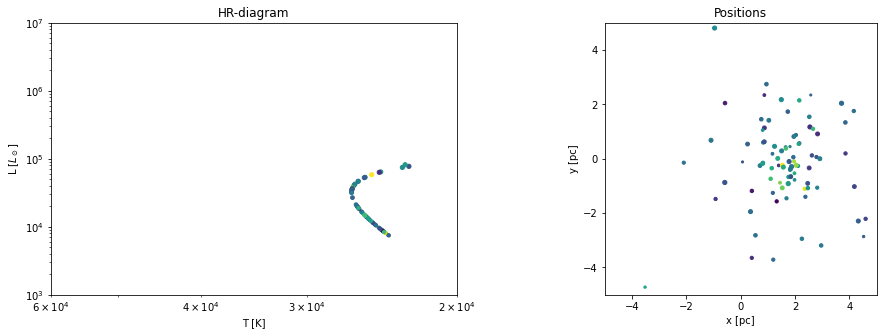

In [4]:
stellar = SeBa()
stellar.particles.add_particles(stars)

gravity = ph4(converter)
gravity.particles.add_particles(stars)
ch_s2g = stellar.particles.new_channel_to(gravity.particles)
ch_g2l = gravity.particles.new_channel_to(stars)
ch_s2l = stellar.particles.new_channel_to(stars)
ch_s2l.copy()

plot_snapshot(stars)

end_time = 10.0 | units.Myr
model_time = 0 | units.Myr
time_gravity = []
time_stellar = []
masses = []
rvir = []
while(model_time<end_time):
    dt = stellar.particles.time_step.min()
    model_time += dt
    stellar.evolve_model(model_time)
    ch_s2g.copy()
    ch_s2l.copy()
    gravity.evolve_model(model_time)
    ch_g2l.copy()
    print("Evolved to t=", stellar.model_time.in_(units.Myr), 
          gravity.model_time.in_(units.Myr),
         "mass=", stars.mass.sum().in_(units.MSun), 
          "rvir=", stars.virial_radius().in_(units.pc))
    time_stellar.append(stellar.model_time.in_(units.Myr).number)
    time_gravity.append(gravity.model_time.in_(units.Myr).number)
    rvir.append(stars.virial_radius().in_(units.pc).number)
    masses.append(stars.mass.sum().in_(units.MSun).number)
    
plot_snapshot(stars)
stellar.stop()
gravity.stop()

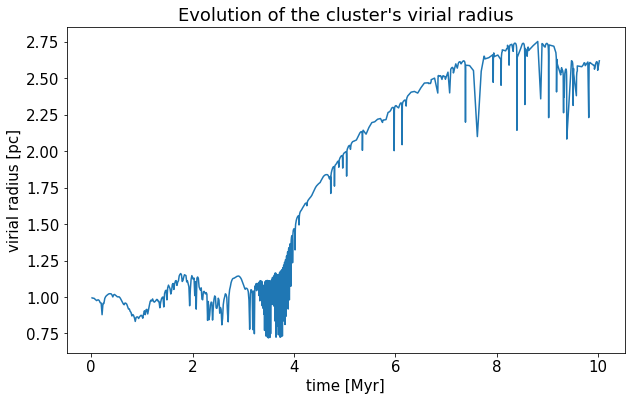

In [10]:
plot(time_stellar, rvir)
plt.xlabel("time [Myr]")
plt.ylabel("virial radius [pc]")
plt.title("Evolution of the cluster's virial radius")
plt.show()

### Question 2:
Why is the cluster expanding?

<span style="color:purple;font-weight:700">
[answer]
</span>

### Question 3:
Why does it take a while before the cluster starts expanding?

<span style="color:purple;font-weight:700">
[answer]
</span>

### Question 4:
The virial radius does not expand monotonously. Why is that?

<span style="color:purple;font-weight:700">
[answer]
</span>

### Assignment 2:
Rerun the calculation without stellar evolution and quantify the difference in which the cluster expands with and without taking stellar evolution into account. 
When rerunning, make sure that you are using the same initial random seed for generating the initial mass function as well as for assigning the stellar positions and velocities.

Can you explain explain the difference between the simulation with- and the one without stellar evolution?

<span style="color:purple;font-weight:700">
[answer]
</span>

### Question 5:
In a previous assignment you have been checking binary formation.
What will happen here if you would continue the run until the first binary forms?

<span style="color:purple;font-weight:700">
[answer]
</span>

### Assignment 6:
Add diagnostic checking for energy conservation to the code.
Make sure to check the energy conservation for stellar evolution and stellar dynamics separately.

### Question 6:
Make a plot of the total, the potential and the kinetic energy of the N-body system as a function of time.

To what degree is the total energy conserved?

<span style="color:purple;font-weight:700">
[answer]
</span>

Is the amount of energy conservation sufficient to warrant a scientifically valid result, and if so, why is this the case?

<span style="color:purple;font-weight:700">
[answer]
</span>

### Assignment 7:
Replace the event-driven approach from the script and replace is with a simple time stepping in which you step-over from one code to the other every million years.

Now check the evolution of the virial radius and the energy conservation of the code again, and discuss the difference with the original event-driven approach.

<span style="color:purple;font-weight:700">
[answer]
</span>